In [1]:
# !pip install shapely

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.max_columns', None)

# Data Loading and Basic Checks

In [3]:
df = pd.read_csv('./data/brimingham_carparks_occupancy.csv')
df.head(2)

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42


In [4]:
df.shape

(35717, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35717 entries, 0 to 35716
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SystemCodeNumber  35717 non-null  object
 1   Capacity          35717 non-null  int64 
 2   Occupancy         35717 non-null  int64 
 3   LastUpdated       35717 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [6]:
# Check duplicated rows
df.duplicated().sum()

216

In [7]:
# Drop duplicated rows
df.drop_duplicates(inplace=True)

In [8]:
# Check missing values
df.isna().sum()

SystemCodeNumber    0
Capacity            0
Occupancy           0
LastUpdated         0
dtype: int64

In [9]:
df.describe()

,Capacity,Occupancy
count,35501.000000,35501.000000
mean,1399.242613,644.853582
std,1179.939451,657.822376
min,220.000000,-8.000000
25%,500.000000,212.000000
50%,863.000000,448.000000
75%,2009.000000,802.000000
max,4675.000000,4327.000000


In [10]:
df.describe(include='O')

,SystemCodeNumber,LastUpdated
count,35501,35501
unique,30,1784
top,BHMBCCMKT01,2016-11-20 16:01:22
freq,1307,29


In [11]:
df

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48
...,...,...,...,...
35712,Shopping,1920,1517,2016-12-19 14:30:33
35713,Shopping,1920,1487,2016-12-19 15:03:34
35714,Shopping,1920,1432,2016-12-19 15:29:33
35715,Shopping,1920,1321,2016-12-19 16:03:35


# Data Cleaning & Extraction of Basic Features

In [12]:
# Define a function to round to the nearest half hour
def round_to_nearest_half_hour(tm):
    # Extract the minute part
    minute = tm.minute
    # print(minute)
    
    if minute<15:
        # Round down to the nearest hour
        return tm.replace(minute=0, second=0)
    elif minute>=15 and minute<45:
        if tm.hour!=7:
            # Round to the nearest half-hour
            return tm.replace(minute=30, second=0)
        else:
            # Round up to the next hour
            new_hour = (tm.hour+1) % 24
            return tm.replace(hour=new_hour, minute=0, second=0) 
    else:
        # Round up to the next hour
        new_hour = (tm.hour+1) % 24
        return tm.replace(hour=new_hour, minute=0, second=0)


def cleaner1(df_inp):
    
    df = df_inp.copy()
    
    df['LastUpdated'] = pd.to_datetime(df['LastUpdated'])
    # df['LastUpdated_Original'] = df['LastUpdated']
    
    # Occupancy Rate  
    df['Occupancy_Rate'] = np.round((100.0*df['Occupancy']/df['Capacity']), 4)

    # Day Related Features
    df['Date'] = pd.to_datetime(df['LastUpdated'].dt.date)
    
    # Will generate the below features later
    # df['DayOfWeek'] = df['LastUpdated'].dt.dayofweek
    # df['isWeekend'] = df['DayOfWeek'].apply(lambda x: True if x in [5, 6] else False)

    # Time Related Features
    df['TimeOfDay_Unclean'] = df['LastUpdated'].dt.time

    # Apply the function to the 'TimeOfDay_Unclean' column
    df['TimeOfDay'] = df['TimeOfDay_Unclean'].apply(round_to_nearest_half_hour)

    # Timestamp
    df['LastUpdated_cln1'] = pd.to_datetime(df['Date'].astype('str') + ' ' + df['TimeOfDay'].astype('str'))

    # Final Touches
    df.drop('TimeOfDay_Unclean', axis=1, inplace=True)
    df.rename({'SystemCodeNumber': 'ParkSpace_ID'}, axis=1, inplace=True)
    df.sort_values(by=['ParkSpace_ID', 'LastUpdated'], ascending=[True, True], inplace=True)

    return df



def cleaner2(df_inp):
    
    df = df_inp.copy()
    
    df_cln_lst = []
    for ps in df.ParkSpace_ID.unique():

        df_tst = df.loc[df.ParkSpace_ID==ps].copy()
        df_tst = df_tst.reset_index(drop=True)

        # Debug
        # print('ParkSpace:', ps)
        # print("Duplicates in (ParkSpace_ID, LastUpdated):", df_tst[['ParkSpace_ID', 'LastUpdated_cln1']].duplicated().sum())
        # print('-'*50)

        df_tst['LastUpdated_cln1_lag'] = df_tst['LastUpdated_cln1'].shift(1)

        # Debug
        # print('Samples where LastUpdated is matching with LastUpdated_Lagged:', df_tst.loc[df_tst['LastUpdated_cln1']==df_tst['LastUpdated_cln1_lag']].shape)
        # print('-'*50)

        prob_idx = df_tst.loc[df_tst['LastUpdated_cln1']==df_tst['LastUpdated_cln1_lag']].index

        # Debug
        # print('Problematic Indexes:', prob_idx)
        # print('-'*50)

        for idx in prob_idx:

            ser_idx = df_tst.iloc[idx]

            # Debug
            # print('Index:', idx)
            # print('Datetime:', ser_idx.loc['LastUpdated_cln1'])
            # print('Datetime Lagged:', ser_idx.loc['LastUpdated_cln1_lag'])


            tm = ser_idx.loc['TimeOfDay']
            tm_min = tm.minute

            if tm_min==30:
                mod_hr = tm.hour + 1
                tm_updt = tm.replace(hour=mod_hr, minute=0, second=0)
            else:
                tm_updt = tm.replace(minute=30, second=0)

            # Debug
            # print('Old time:', tm)
            # print('Updated Time:', tm_updt)

            
            # ---------------- XX ----------------
            # Check the index of 'TimeOfDay'
            # ---------------- XX ----------------
            tod_idx = 6
            # Update the corrected time
            df_tst.iloc[idx, tod_idx] = tm_updt

            # Debug
            # print(df_tst.iloc[idx, tod_idx])
            # print('-'*50)


        # Timestamp
        df_tst['LastUpdated_cln2'] = pd.to_datetime(df_tst['Date'].astype('str') + ' ' + df_tst['TimeOfDay'].astype('str'))
        
        # Will generate the below features later
        # df_tst['Hour'] = pd.to_datetime(df_tst['LastUpdated_cln2']).dt.hour
        # df_tst['Minute'] = pd.to_datetime(df_tst['LastUpdated_cln2']).dt.minute

        
        # Debug
        # print("Duplicates in (ParkSpace_ID, LastUpdated):", df_tst[['ParkSpace_ID', 'LastUpdated_cln2']].duplicated().sum())
        # print('-'*100)
        
        
        df_cln_lst.append(df_tst)
        
        
    df_concatted = pd.concat(df_cln_lst, axis=0)
    df_concatted.sort_values(by=['ParkSpace_ID', 'LastUpdated_cln2'], ascending=[True, True], inplace=True)
    
    return df_concatted




df_cln1 = cleaner1(df_inp=df)
df_cln2 = cleaner2(df_inp=df_cln1)
df_cln2 = df_cln2[['ParkSpace_ID', 'Capacity', 'LastUpdated', 'Occupancy', 'Occupancy_Rate', 
                   'LastUpdated_cln1', 'LastUpdated_cln2', 'Date', 'TimeOfDay']]
df_cln2.head(3)

,ParkSpace_ID,Capacity,LastUpdated,Occupancy,Occupancy_Rate,LastUpdated_cln1,LastUpdated_cln2,Date,TimeOfDay
0,BHMBCCMKT01,577,2016-10-04 07:59:42,61,10.5719,2016-10-04 08:00:00,2016-10-04 08:00:00,2016-10-04,08:00:00
1,BHMBCCMKT01,577,2016-10-04 08:25:42,64,11.0919,2016-10-04 08:30:00,2016-10-04 08:30:00,2016-10-04,08:30:00
2,BHMBCCMKT01,577,2016-10-04 08:59:42,80,13.8648,2016-10-04 09:00:00,2016-10-04 09:00:00,2016-10-04,09:00:00


As seen from below, post the data cleaning where we have rounded off the datetime to the nearest 30min:
- We see some duplicates in the data.
- Upon investigating, we see that the duplicates arise because it does match perfectly with the round-off criteria & cleaning steps that are being used.
- Fortunately (post 2nd round of cleaning) we have very a few number of duplicates and thus it makes to drop them. 
- However, this will introduce some missing points but we will handle them later using imputation techniques.

In [13]:
# Duplicates after 1st cleaning
df_cln1[['ParkSpace_ID', 'LastUpdated_cln1']].duplicated().sum()

54

In [14]:
# Dup;icates after 2nd cleaning
df_cln2[['ParkSpace_ID', 'LastUpdated_cln2']].duplicated().sum()

3

In [15]:
df_cln2.loc[df_cln2[['ParkSpace_ID', 'LastUpdated_cln2']].duplicated()]

,ParkSpace_ID,Capacity,LastUpdated,Occupancy,Occupancy_Rate,LastUpdated_cln1,LastUpdated_cln2,Date,TimeOfDay
948,BHMNCPNST01,485,2016-11-28 10:05:28,284,58.5567,2016-11-28 10:00:00,2016-11-28 10:00:00,2016-11-28,10:00:00
1047,BHMNCPPLS01,450,2016-12-08 08:39:22,39,8.6667,2016-12-08 08:30:00,2016-12-08 08:30:00,2016-12-08,08:30:00
1168,BHMNCPPLS01,450,2016-12-15 09:10:05,49,10.8889,2016-12-15 09:00:00,2016-12-15 09:00:00,2016-12-15,09:00:00


In [16]:
df_cln2.loc[(df_cln2.Date=='2016-11-28') & 
            (df_cln2.ParkSpace_ID=='BHMNCPNST01') & 
            (df_cln2.LastUpdated_cln2.dt.hour>=8) & (df_cln2.LastUpdated_cln2.dt.hour<=11)
           ] # 09:42

,ParkSpace_ID,Capacity,LastUpdated,Occupancy,Occupancy_Rate,LastUpdated_cln1,LastUpdated_cln2,Date,TimeOfDay
945,BHMNCPNST01,485,2016-11-28 07:42:26,193,39.7938,2016-11-28 08:00:00,2016-11-28 08:00:00,2016-11-28,08:00:00
946,BHMNCPNST01,485,2016-11-28 09:22:29,250,51.5464,2016-11-28 09:30:00,2016-11-28 09:30:00,2016-11-28,09:30:00
947,BHMNCPNST01,485,2016-11-28 09:42:26,268,55.2577,2016-11-28 09:30:00,2016-11-28 10:00:00,2016-11-28,10:00:00
948,BHMNCPNST01,485,2016-11-28 10:05:28,284,58.5567,2016-11-28 10:00:00,2016-11-28 10:00:00,2016-11-28,10:00:00
949,BHMNCPNST01,485,2016-11-28 10:42:28,300,61.8557,2016-11-28 10:30:00,2016-11-28 10:30:00,2016-11-28,10:30:00
950,BHMNCPNST01,485,2016-11-28 11:12:25,308,63.5052,2016-11-28 11:00:00,2016-11-28 11:00:00,2016-11-28,11:00:00
951,BHMNCPNST01,485,2016-11-28 11:42:30,322,66.3918,2016-11-28 11:30:00,2016-11-28 11:30:00,2016-11-28,11:30:00


In [17]:
df_cln_final = df_cln2.copy()
df_cln_final['LastUpdated'] = df_cln_final['LastUpdated_cln2']
df_cln_final.drop(['LastUpdated_cln1', 'LastUpdated_cln2'], axis=1, inplace=True)
df_cln_final.head(2)

,ParkSpace_ID,Capacity,LastUpdated,Occupancy,Occupancy_Rate,Date,TimeOfDay
0,BHMBCCMKT01,577,2016-10-04 08:00:00,61,10.5719,2016-10-04,08:00:00
1,BHMBCCMKT01,577,2016-10-04 08:30:00,64,11.0919,2016-10-04,08:30:00


In [18]:
print('#Duplicates:', df_cln_final.duplicated(subset=['ParkSpace_ID', 'LastUpdated']).sum())
print('Shape before dropping duplicates:', df_cln_final.shape)
df_cln_final.drop_duplicates(subset=['ParkSpace_ID', 'LastUpdated'], inplace=True)
print('Shape post dropping duplicates:', df_cln_final.shape)

#Duplicates: 3
Shape before dropping duplicates: (35501, 7)
Shape post dropping duplicates: (35498, 7)


# Filtering Data: To account for Faulty Data / Missing Days

In [19]:
# pd.to_datetime('2016-12-19') - pd.to_datetime('2016-10-04')

In [20]:
print('Earliest Day:', df_cln_final.Date.min())
print('Latest Day:', df_cln_final.Date.max())
print(f'Duration of Data: {(df_cln_final.Date.max() - df_cln_final.Date.min()).days+1} days')

Earliest Day: 2016-10-04 00:00:00
Latest Day: 2016-12-19 00:00:00
Duration of Data: 77 days


## Day-Level Check: Count of Days per ParkSpace

In [21]:
df_agg_ps_date_stats = df_cln_final.groupby('ParkSpace_ID')[['Date']].agg(['nunique', 'min', 'max'])
df_agg_ps_date_stats.columns = [('_').join(tup) for tup in df_agg_ps_date_stats.columns]
df_agg_ps_date_stats.sort_values(by='Date_nunique', ascending=True)

,Date_nunique,Date_min,Date_max
ParkSpace_ID,,,
BHMBRTARC01,5,2016-12-13,2016-12-18
NIA North,9,2016-10-16,2016-11-30
BHMNCPNHS01,58,2016-10-04,2016-12-19
Bull Ring,66,2016-10-04,2016-12-19
BHMBRCBRG03,66,2016-10-04,2016-12-19
BHMNCPRAN01,66,2016-10-04,2016-12-19
BHMBRCBRG01,66,2016-10-04,2016-12-19
BHMBRCBRG02,66,2016-10-04,2016-12-19
NIA Car Parks,67,2016-10-04,2016-12-16


Will be excluding the below car parks owing to less #days in the time series:
- BHMBRTARC01 (severely low)
- NIA North (severely low)
- BHMNCPNHS01 (moderately low)

In [22]:
df_filt1 = df_cln_final.loc[~df_cln_final.ParkSpace_ID.isin(['BHMBRTARC01', 'NIA North', 'BHMNCPNHS01'])].copy()
# df_filt1['Date'] = df_filt1['Date'].astype('str')
df_filt1['Hour'] = df_filt1['LastUpdated'].dt.hour.astype('int')
df_filt1.shape

(34223, 8)

In [23]:
df_filt1.head()

,ParkSpace_ID,Capacity,LastUpdated,Occupancy,Occupancy_Rate,Date,TimeOfDay,Hour
0,BHMBCCMKT01,577,2016-10-04 08:00:00,61,10.5719,2016-10-04,08:00:00,8
1,BHMBCCMKT01,577,2016-10-04 08:30:00,64,11.0919,2016-10-04,08:30:00,8
2,BHMBCCMKT01,577,2016-10-04 09:00:00,80,13.8648,2016-10-04,09:00:00,9
3,BHMBCCMKT01,577,2016-10-04 09:30:00,107,18.5442,2016-10-04,09:30:00,9
4,BHMBCCMKT01,577,2016-10-04 10:00:00,150,25.9965,2016-10-04,10:00:00,10


## Hour level Check: Count of Hours/Day per ParkSpace

In [24]:
# Unique Hours
df_filt1.Hour.value_counts().sort_index()

8     3746
9     3787
10    3829
11    3804
12    3821
13    3804
14    3829
15    3830
16    3773
Name: Hour, dtype: int64

Expectations:
- For each day, we have data from 8AM upto 5PM in intervals of 30 minutes. 
- So thus for each day we should be having (9*2) = 18points

In [25]:
# Aggregate by parkspace & date
df_filt1_agg_ps_date_hr_stats = df_filt1.groupby(['ParkSpace_ID', 'Date'])[['Hour']].agg('count').reset_index()
df_filt1_agg_ps_date_hr_stats['Total_Hrs'] = df_filt1_agg_ps_date_hr_stats.groupby('ParkSpace_ID')['Hour'].transform('sum')
df_filt1_agg_ps_date_hr_stats.rename({'Hour':'Daily_Hrs'}, axis=1, inplace=True)
df_filt1_agg_ps_date_hr_stats

,ParkSpace_ID,Date,Daily_Hrs,Total_Hrs
0,BHMBCCMKT01,2016-10-04,18,1307
1,BHMBCCMKT01,2016-10-05,18,1307
2,BHMBCCMKT01,2016-10-06,18,1307
3,BHMBCCMKT01,2016-10-07,18,1307
4,BHMBCCMKT01,2016-10-08,18,1307
...,...,...,...,...
1911,Shopping,2016-12-15,18,1307
1912,Shopping,2016-12-16,18,1307
1913,Shopping,2016-12-17,18,1307
1914,Shopping,2016-12-18,18,1307


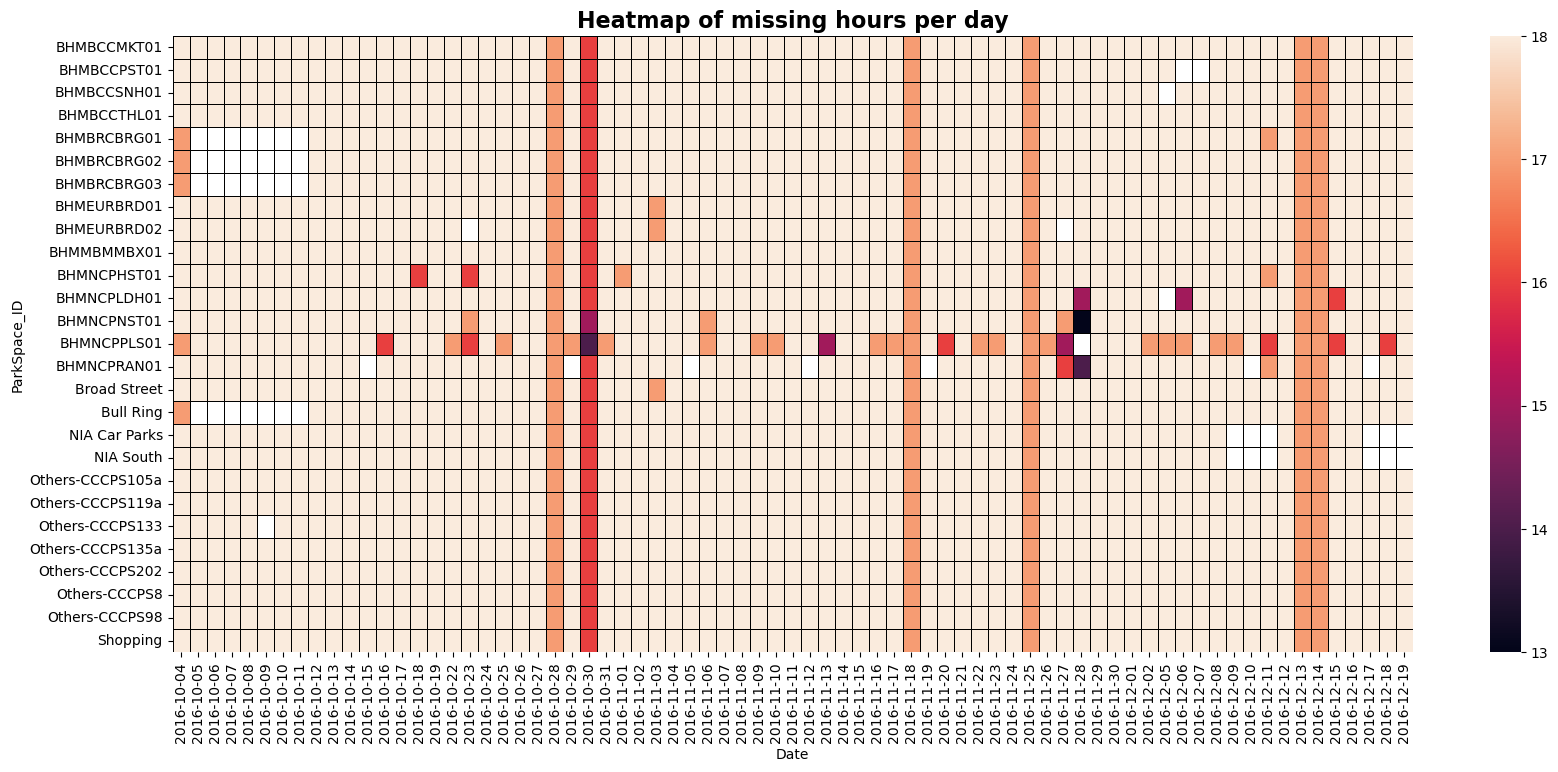

In [26]:
plt.figure(figsize=(20, 8))
df_filt1_agg_ps_date_hr_stats_cp = df_filt1_agg_ps_date_hr_stats.copy()
df_filt1_agg_ps_date_hr_stats_cp['Date'] = df_filt1_agg_ps_date_hr_stats_cp['Date'].astype('str')
sns.heatmap(df_filt1_agg_ps_date_hr_stats_cp.pivot(index='ParkSpace_ID', columns='Date', values='Daily_Hrs'), 
            # cmap='copper',
            # annot=True, fmt=".1f", 
            linewidth=0.5, linecolor='black')
plt.title('Heatmap of missing hours per day', fontweight='bold', fontsize=16)
plt.show()

**Observations:**
- We can see that the minimum number of hours present across any day is 14 hours
- We can see 2 kinds of data issues (missing hours):
    - Day wise problem (28th October, 30th October, 18th November, 25th November, 13th December, 14th December):
        - All parking spaces are having missing hours throughout the day
    - Parking Space wise problem:
        - There are a few parking spaces which are having missings hours across some days
        - Also for a few parking spaces, the entire day is missing (notice the white cells)

In [27]:
# Aggregate by date
df_sanity_agg_date_ps_stats = df_filt1_agg_ps_date_hr_stats.groupby('Date')[['ParkSpace_ID']].nunique().reset_index()
df_sanity_agg_date_ps_stats['Consecutive_Day_Gap'] = df_sanity_agg_date_ps_stats.Date.diff(1).apply(lambda x: x.days)
df_sanity_agg_date_ps_stats.sort_values('Date', ascending=True, inplace=True)
df_sanity_agg_date_ps_stats.set_index('Date', inplace=True)
df_sanity_agg_date_ps_stats.rename({'ParkSpace_ID':'Count_ParkSpaces'}, axis=1, inplace=True)
df_sanity_agg_date_ps_stats

,Count_ParkSpaces,Consecutive_Day_Gap
Date,,
2016-10-04,27,NaN
2016-10-05,23,1.0
2016-10-06,23,1.0
2016-10-07,23,1.0
2016-10-08,23,1.0
...,...,...
2016-12-15,27,1.0
2016-12-16,27,1.0
2016-12-17,24,1.0


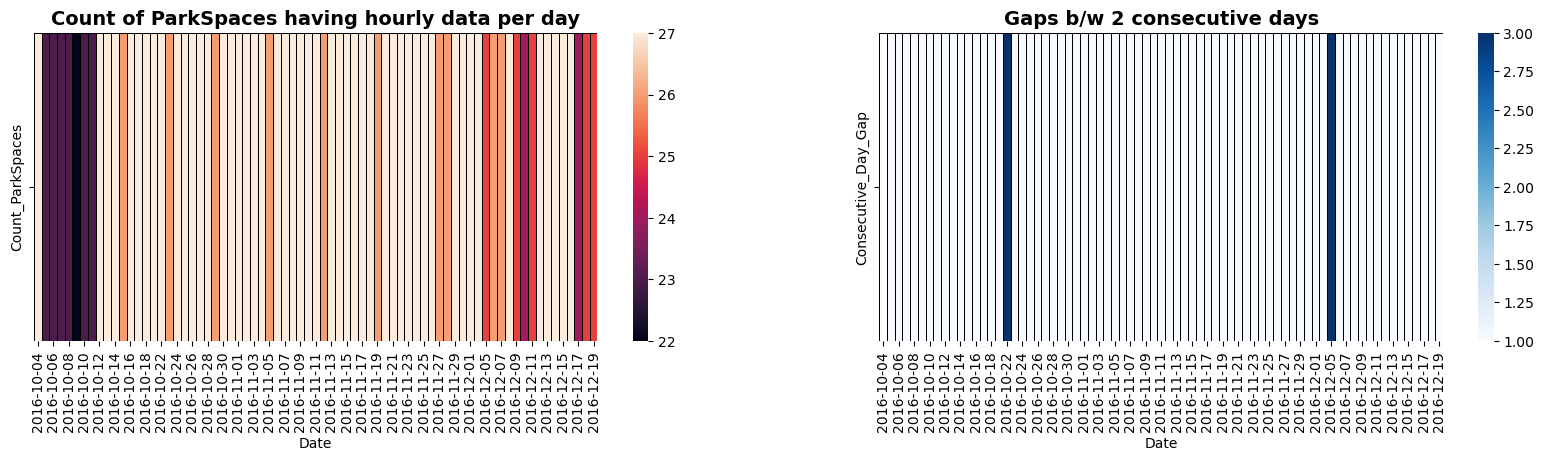

In [28]:
plt.figure(figsize=(20, 4))

df_sanity_agg_date_ps_stats_cp = df_sanity_agg_date_ps_stats.copy()

df_sanity_agg_date_ps_stats_cp = df_sanity_agg_date_ps_stats_cp.reset_index()
df_sanity_agg_date_ps_stats_cp['Date'] = df_sanity_agg_date_ps_stats_cp['Date'].astype('str')
df_sanity_agg_date_ps_stats_cp = df_sanity_agg_date_ps_stats_cp.set_index('Date')

plt.subplot(1, 2, 1)
sns.heatmap(df_sanity_agg_date_ps_stats_cp[['Count_ParkSpaces']].T, 
            # cmap='Blues',
            # annot=True, fmt=".1f", 
            linewidth=0.5, linecolor='black')
plt.title('Count of ParkSpaces having hourly data per day', fontweight='bold', fontsize=14)

plt.subplot(1, 2, 2)
sns.heatmap(df_sanity_agg_date_ps_stats_cp[['Consecutive_Day_Gap']].T, 
            cmap='Blues',
            # annot=True, fmt=".1f", 
            linewidth=0.5, linecolor='black')
plt.title('Gaps b/w 2 consecutive days', fontweight='bold', fontsize=14)

plt.show()

**Observations:**

- From 1st Heatmap:
    - We see that there are a few days where data is missing for the complete day for some parking spaces
- From 2nd Heatmap:
    - There are 2 instances where data is missing for the complete day for ALL parking spaces.
    - The days which are missing are: 
        - Instance1: (20th October, 21st October)
        - Instance2: (3rd December, 4th December)

## Hour Level Check: Occupancy Rate Variability

In [29]:
def q15(x):
    return x.quantile(0.15)

def q85(x):
    return x.quantile(0.85)


df_filt1_agg_ps_date_or_stats = df_filt1.groupby(['ParkSpace_ID', 'Date'])[['Occupancy_Rate']].agg(['mean', 'std', 'min', 'max', q15, q85])
df_filt1_agg_ps_date_or_stats.columns = ['_'.join(['OR', tup[-1]]) for tup in df_filt1_agg_ps_date_or_stats.columns]
# df_filt1_agg_ps_date_or_stats['OR_range'] = df_filt1_agg_ps_date_or_stats['OR_max'] - df_filt1_agg_ps_date_or_stats['OR_min']
df_filt1_agg_ps_date_or_stats['OR_range'] = df_filt1_agg_ps_date_or_stats['OR_q85'] - df_filt1_agg_ps_date_or_stats['OR_q15']
df_filt1_agg_ps_date_or_stats.reset_index(inplace=True)
df_filt1_agg_ps_date_or_stats

,ParkSpace_ID,Date,OR_mean,OR_std,OR_min,OR_max,OR_q15,OR_q85,OR_range
0,BHMBCCMKT01,2016-10-04,31.552089,12.246725,10.5719,46.6205,16.438470,45.199285,28.760815
1,BHMBCCMKT01,2016-10-05,22.867322,7.385174,9.3588,31.7158,13.448835,30.563255,17.114420
2,BHMBCCMKT01,2016-10-06,26.092811,8.742285,10.0520,36.0485,14.514740,34.566685,20.051945
3,BHMBCCMKT01,2016-10-07,26.920856,8.829117,10.0520,36.3951,15.667285,34.740030,19.072745
4,BHMBCCMKT01,2016-10-08,46.187183,22.269101,10.0520,70.3640,15.762600,68.457500,52.694900
...,...,...,...,...,...,...,...,...,...
1911,Shopping,2016-12-15,66.660883,14.150638,30.6250,78.5938,53.552065,78.145850,24.593785
1912,Shopping,2016-12-16,60.083917,11.422113,30.2083,71.0938,49.903620,69.406270,19.502650
1913,Shopping,2016-12-17,43.142367,14.592564,18.6979,60.0521,24.645815,57.940145,33.294330
1914,Shopping,2016-12-18,34.843750,12.664028,17.6042,50.9375,19.281235,49.023465,29.742230


In [30]:
# df_filt1_agg_ps_date_or_stats.groupby('ParkSpace_ID')['OR_std'].mean()
# df_filt1_agg_ps_date_or_stats.groupby('ParkSpace_ID')['OR_range'].mean()

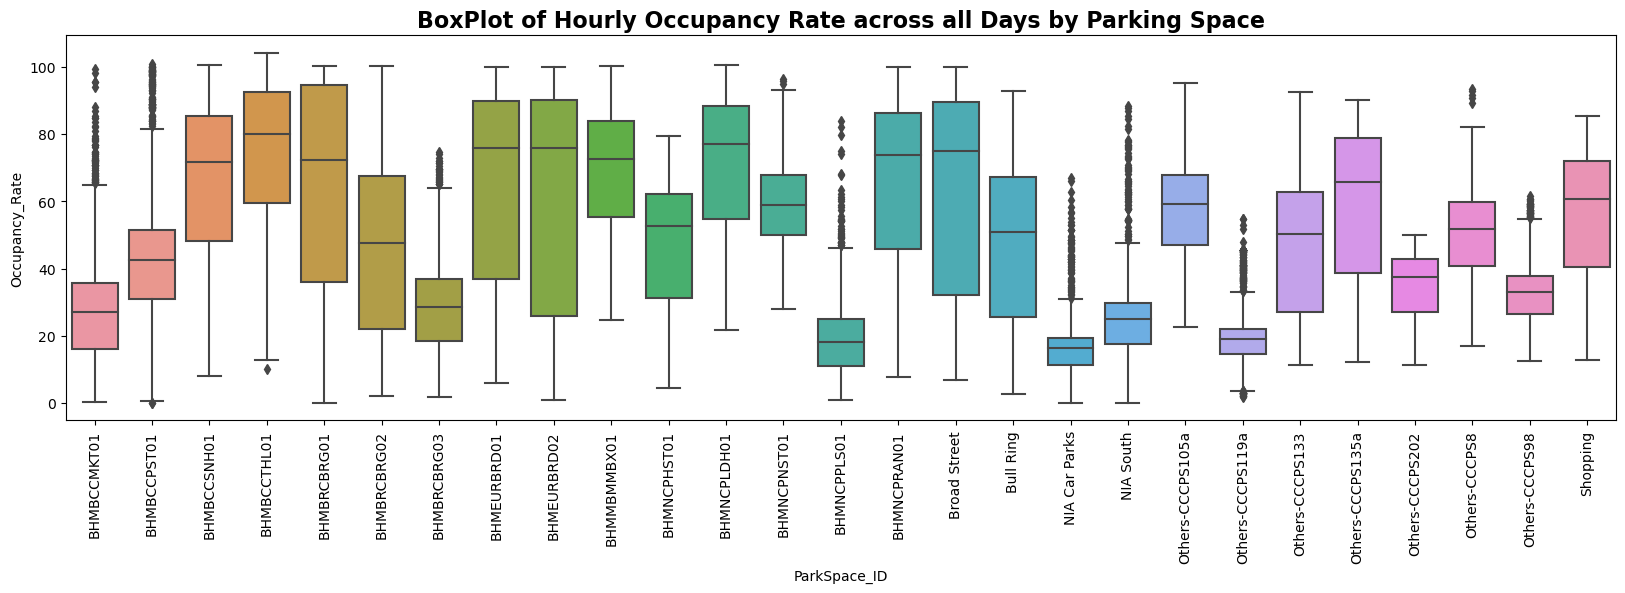

In [31]:
plt.figure(figsize=(20, 5))
sns.boxplot(data=df_filt1, y='Occupancy_Rate', x='ParkSpace_ID')
plt.xticks(rotation=90)
plt.title('BoxPlot of Hourly Occupancy Rate across all Days by Parking Space', fontweight='bold', fontsize=16)
plt.show()

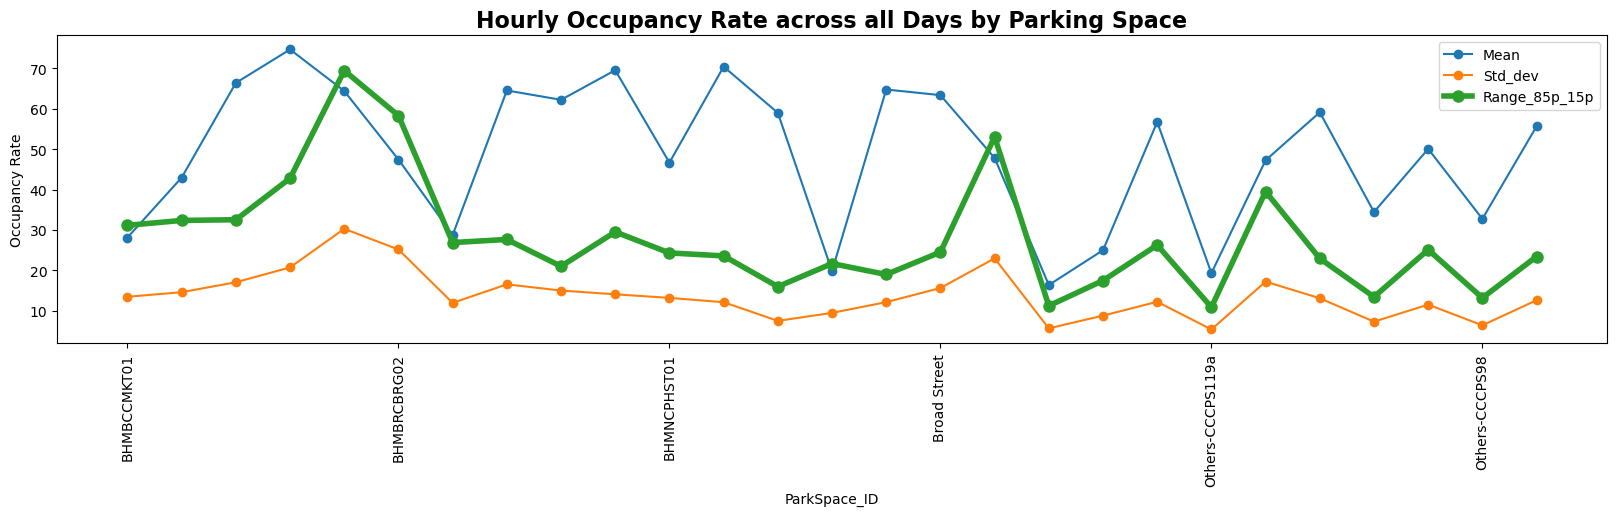

In [32]:
plt.figure(figsize=(20, 4))
df_filt1_agg_ps_date_or_stats.groupby('ParkSpace_ID')['OR_mean'].mean().plot(marker='o', label='Mean')
df_filt1_agg_ps_date_or_stats.groupby('ParkSpace_ID')['OR_std'].mean().plot(marker='o', label='Std_dev')
df_filt1_agg_ps_date_or_stats.groupby('ParkSpace_ID')['OR_range'].mean().plot(marker='o', label='Range_85p_15p', linewidth=4, markersize=8)

plt.xticks(rotation=90)
plt.title('Hourly Occupancy Rate across all Days by Parking Space', fontweight='bold', fontsize=16)
plt.ylabel('Occupancy Rate')
plt.legend()
plt.show()

# Imputing Missing Values Strategy:

We follow the below imputation strategy for the time series data for each park space:

- If the entire data for the day is missing, we replicate data from the previous weekday.
    - For example: If data for Friday 9th is missing, we fill the missing day with the previous weekday data (Friday 2nd).
    - If data for Friday 2nd is not available in the dataset, we fill the missing day with the following weekday data.
  
- If the day has a few missing hours, we use the backfill/forwardfill strategy

In [33]:
dates = pd.date_range(start='2016-10-04', end='2016-12-19', freq='D')

# Define the time range (08:00 to 16:30, 17:00 excluded)
times = pd.date_range(start='08:00', end='16:30', freq='30min').time

datetime_list = []

# Combine dates and times
for date in dates:
    for time in times:
        datetime_list.append(pd.Timestamp.combine(date, time))
        
# Convert the list to a DataFrame (optional)
df_datetime = pd.DataFrame(datetime_list, columns=['LastUpdated'])
df_datetime['Date'] = df_datetime['LastUpdated'].dt.date
df_datetime

,LastUpdated,Date
0,2016-10-04 08:00:00,2016-10-04
1,2016-10-04 08:30:00,2016-10-04
2,2016-10-04 09:00:00,2016-10-04
3,2016-10-04 09:30:00,2016-10-04
4,2016-10-04 10:00:00,2016-10-04
...,...,...
1381,2016-12-19 14:30:00,2016-12-19
1382,2016-12-19 15:00:00,2016-12-19
1383,2016-12-19 15:30:00,2016-12-19
1384,2016-12-19 16:00:00,2016-12-19


## Imputation Function

In [34]:
def ts_imputer(df, df_datetime):
    
    df_post_impute_dict = {}
    
    # DF before imputation
    df_preimpute = df[['LastUpdated', 'ParkSpace_ID', 'Capacity', 'Occupancy', 'Occupancy_Rate']].copy()

    
    # Identifying unique parkspaces
    parkspaces = df_preimpute['ParkSpace_ID'].unique()
    # parkspaces = ['BHMBRCBRG02']

    for ps in parkspaces[:]:
        
        # Debug:
        # print('Park Space:', ps)
        # print('-'*50)

        # Filtering the parkspace first
        df_preimpute_filt = df_preimpute.loc[df_preimpute['ParkSpace_ID']==ps]

        # Debug:
        # print('Shape before imputing:', df_preimpute_filt.shape)
        # print('Duplicates before imputing:', df_preimpute_filt.duplicated(subset=['ParkSpace_ID', 'LastUpdated']).sum())
        # print('-'*50)
        
        
        # Ensuring all timestamps are present
        df_pstimpute_filt = pd.merge(df_datetime, df_preimpute_filt, on='LastUpdated', how='left')
        df_pstimpute_filt['TimeStamp'] = df_pstimpute_filt['LastUpdated']
        df_pstimpute_filt.set_index('LastUpdated', inplace=True)
        
        # Debug:
        # print('Shape post merging:', df_pstimpute_filt.shape)
        # print('Duplicates post merging:', df_pstimpute_filt.duplicated(subset=['ParkSpace_ID', 'TimeStamp']).sum())
        # print('-'*50)
        
    

        
        # -------------------------------- XX -------------------------------- XX --------------------------------
        # Step 1: Impute completely missing days with closest weekday: Ex: 11th Oct is imputed wth 4th Oct or 19th Oct
        # -------------------------------- XX -------------------------------- XX --------------------------------
        
        # Identify missing days
        ser_agg_pts_by_dt = df_pstimpute_filt.groupby('Date')['Occupancy_Rate'].count()
        missing_days = ser_agg_pts_by_dt.loc[ser_agg_pts_by_dt==0].index
        
        # Debug:
        # print('Missing Days:', missing_days)
        # print('-'*50)

        # Impute missing day with nearest weekday
        for missing_day in missing_days:
            
            # Debug:
            # print(missing_day)
            # print('-'*50)

            # Find the same weekday from either the previous or next week
            prev_weekday = missing_day - pd.Timedelta(days=7)
            next_weekday = missing_day + pd.Timedelta(days=7)

            if prev_weekday in df_pstimpute_filt.index.date:
                df_nearest_weekday = df_pstimpute_filt[df_pstimpute_filt.index.date == prev_weekday]
            elif next_weekday in df_pstimpute_filt.index.date:
                df_nearest_weekday = df_pstimpute_filt[df_pstimpute_filt.index.date == next_weekday]
            else:
                continue  # If neither is found, skip imputation

            # Adjust the dates for imputation
            df_missing = df_nearest_weekday.copy()
            df_missing.index = df_missing.index.map(lambda dt: dt.replace(year=missing_day.year, month=missing_day.month, day=missing_day.day))
            df_pstimpute_filt.loc[df_missing.index, :] = df_missing
            
        
        # Re-evaluate the 'timestamp' column again
        df_pstimpute_filt['TimeStamp'] = df_pstimpute_filt.index


        # Imputing the static fields
        df_pstimpute_filt['ParkSpace_ID'].fillna(ps, inplace=True)
        df_pstimpute_filt['Capacity'].fillna(df_pstimpute_filt['Capacity'].min(), inplace=True)
        
        # Ensuring that the datetime index is sorted
        df_pstimpute_filt.sort_index(ascending=True, inplace=True)
        
        
        # -------------------------------- XX -------------------------------- XX --------------------------------
        # Step 2: Impute missing hours in a day with linear interpolation
        # -------------------------------- XX -------------------------------- XX --------------------------------


        # Imputing the time-varying fields
        # Trail 1: Using Linear Interpolation
        # df_pstimpute_filt['Occupancy'] = df_pstimpute_filt['Occupancy'].interpolate(method='linear')
        # df_pstimpute_filt['Occupancy_Rate'] = df_pstimpute_filt['Occupancy_Rate'].interpolate(method='linear')
            
        # Trail 2: Using Only Back-Fill
        # df_pstimpute_filt['Occupancy'].fillna(method='bfill', inplace=True)
        # df_pstimpute_filt['Occupancy_Rate'].fillna(method='bfill', inplace=True)
        
        
        # Trail 3: Using Back-Fill + Forward-Fill
        df_pstimpute_filt['Occupancy'] = df_pstimpute_filt.groupby('Date')['Occupancy'].fillna(method='bfill')
        df_pstimpute_filt['Occupancy'] = df_pstimpute_filt.groupby('Date')['Occupancy'].fillna(method='ffill')
        
        df_pstimpute_filt['Occupancy_Rate'] = df_pstimpute_filt.groupby('Date')['Occupancy_Rate'].fillna(method='bfill')
        df_pstimpute_filt['Occupancy_Rate'] = df_pstimpute_filt.groupby('Date')['Occupancy_Rate'].fillna(method='ffill')
            
        
        # Debug:
        # print('Shape post merging:', df_pstimpute_filt.shape)
        # print('Duplicates post imputation:', df_pstimpute_filt.duplicated(subset=['ParkSpace_ID', 'TimeStamp']).sum())
        # print('-'*50)

        # Debug:
        # print('Missing values:')
        # print(df_pstimpute_filt.isna().sum().loc[df_pstimpute_filt.isna().sum()>0])
        # print('-'*100)
        
        
        # Adding imputed time series to the dictionary
        df_post_impute_dict[ps] = df_pstimpute_filt
        
    return df_post_impute_dict



post_impute_dict = ts_imputer(df=df_filt1, df_datetime=df_datetime)

# viz_parkspace = 'BHMBRCBRG02'
# post_impute_dict[viz_parkspace]

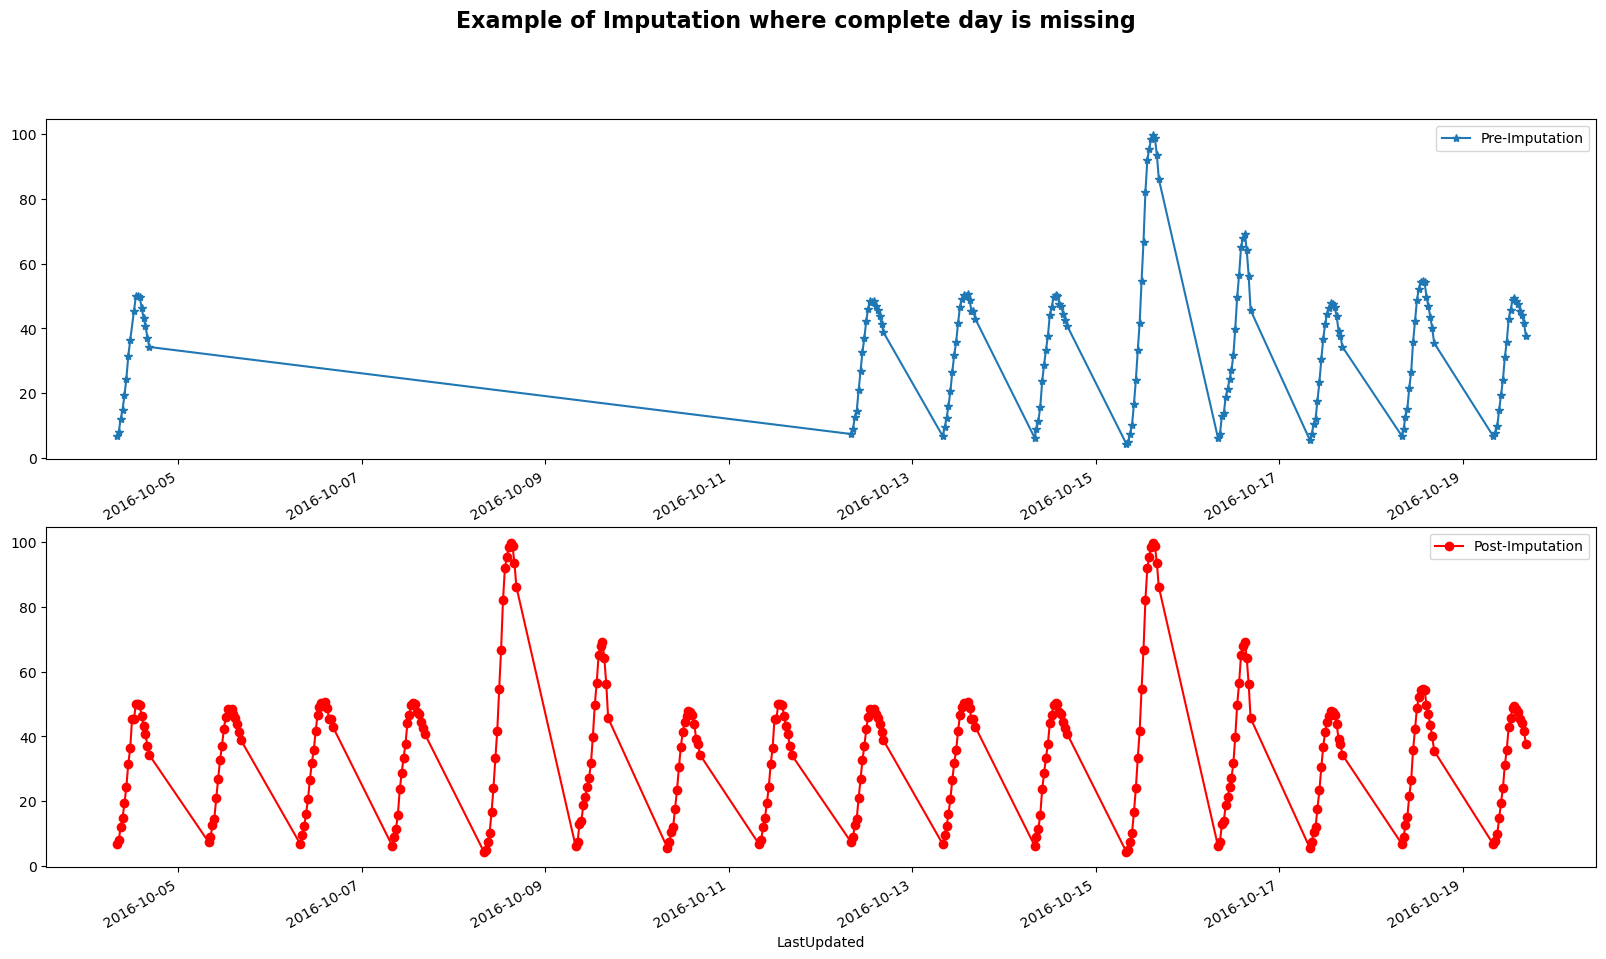

In [35]:
# Example: 1
viz_parkspace = 'BHMBRCBRG02'
start_datetime = '2016-10-04'
end_datetime = '2016-10-19'
# start_datetime = '2016-10-11'
# end_datetime = '2016-10-13'


plt.figure(figsize=(20, 11))

plt.subplot(2, 1, 1)
# Visualize data before imputation
df_filt1.loc[(df_filt1.ParkSpace_ID==viz_parkspace) &  
             (df_filt1.LastUpdated.dt.date.astype('str')>=start_datetime) &  
             (df_filt1.LastUpdated.dt.date.astype('str')<=end_datetime)
            ].set_index('LastUpdated')['Occupancy_Rate'].plot(marker='*', label='Pre-Imputation')

plt.legend()


plt.subplot(2, 1, 2)
# Visualize data post imputation
post_impute_dict[viz_parkspace].loc[(post_impute_dict[viz_parkspace].index.date.astype('str')>=start_datetime) &    
                                    (post_impute_dict[viz_parkspace].index.date.astype('str')<=end_datetime)   
                                   ]['Occupancy_Rate'].plot(marker='o', color='r', label='Post-Imputation')


plt.suptitle('Example of Imputation where complete day is missing', fontweight='bold', fontsize=16)
plt.legend()
plt.show()

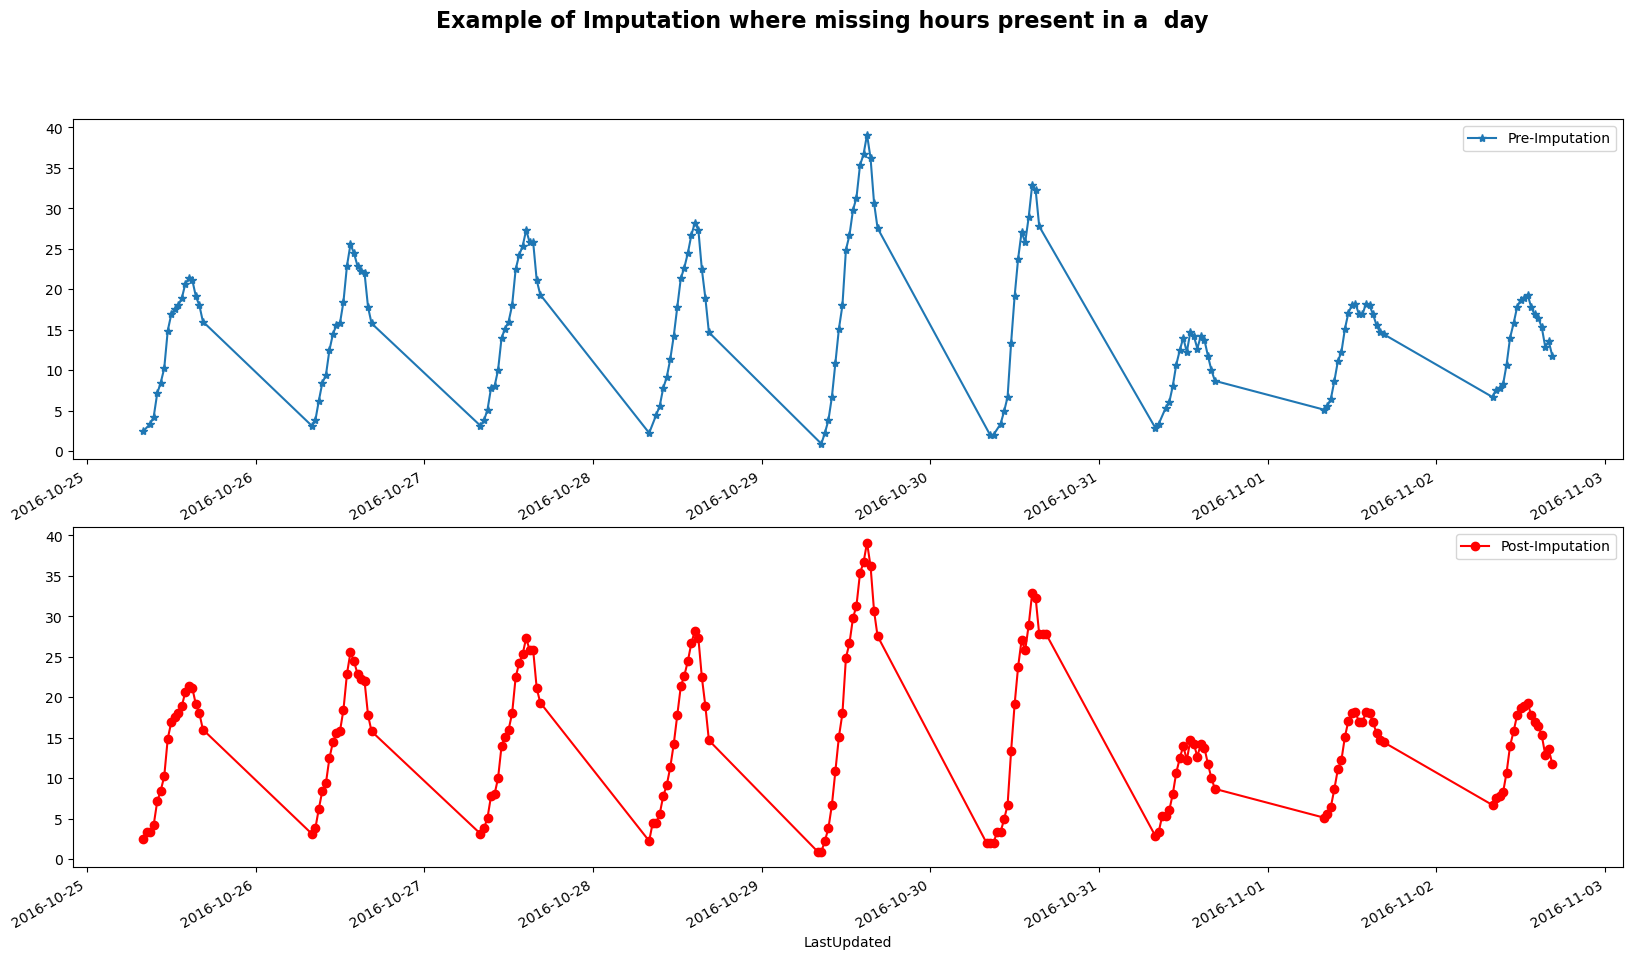

In [36]:
# Example: 2
viz_parkspace = 'BHMNCPPLS01'
start_datetime = '2016-10-25'
end_datetime = '2016-11-02'

plt.figure(figsize=(20, 11))

plt.subplot(2, 1, 1)
# Visualize data before imputation
df_filt1.loc[(df_filt1.ParkSpace_ID==viz_parkspace) &  
             (df_filt1.LastUpdated.dt.date.astype('str')>=start_datetime) &  
             (df_filt1.LastUpdated.dt.date.astype('str')<=end_datetime)
            ].set_index('LastUpdated')['Occupancy_Rate'].plot(marker='*', label='Pre-Imputation')

plt.legend()


plt.subplot(2, 1, 2)
# Visualize data post imputation
post_impute_dict[viz_parkspace].loc[(post_impute_dict[viz_parkspace].index.date.astype('str')>=start_datetime) &    
                                    (post_impute_dict[viz_parkspace].index.date.astype('str')<=end_datetime)   
                                   ]['Occupancy_Rate'].plot(marker='o', color='r', label='Post-Imputation')


plt.suptitle('Example of Imputation where missing hours present in a  day', fontweight='bold', fontsize=16)
plt.legend()
plt.show()

## Generating dataframe post imputation

In [37]:
len(post_impute_dict.keys())

27

In [38]:
df_imputed_lst = []

for key in post_impute_dict.keys():
    df_imputed_by_ps = post_impute_dict[key]
    df_imputed_lst.append(df_imputed_by_ps)

df_imputed = pd.concat(df_imputed_lst).reset_index()
df_imputed.drop('LastUpdated', axis=1, inplace=True)

print('Shape of imputed dataset:', df_imputed.shape)
print('-'*50)
print('Duplicates Present:', df_imputed[['ParkSpace_ID', 'TimeStamp']].duplicated().sum())
print('-'*50)
print('Missing Values:')
print(df_imputed.isna().sum())
print('-'*100)

df_imputed.set_index('TimeStamp', inplace=True)
df_imputed = df_imputed[['ParkSpace_ID', 'Capacity', 'Occupancy', 'Occupancy_Rate', 'Date']]
df_imputed.head()

Shape of imputed dataset: (37422, 6)
--------------------------------------------------
Duplicates Present: 0
--------------------------------------------------
Missing Values:
Date              0
ParkSpace_ID      0
Capacity          0
Occupancy         0
Occupancy_Rate    0
TimeStamp         0
dtype: int64
----------------------------------------------------------------------------------------------------


,ParkSpace_ID,Capacity,Occupancy,Occupancy_Rate,Date
TimeStamp,,,,,
2016-10-04 08:00:00,BHMBCCMKT01,577.0,61.0,10.5719,2016-10-04
2016-10-04 08:30:00,BHMBCCMKT01,577.0,64.0,11.0919,2016-10-04
2016-10-04 09:00:00,BHMBCCMKT01,577.0,80.0,13.8648,2016-10-04
2016-10-04 09:30:00,BHMBCCMKT01,577.0,107.0,18.5442,2016-10-04
2016-10-04 10:00:00,BHMBCCMKT01,577.0,150.0,25.9965,2016-10-04


## Generating the individual time series

In [39]:
ts_dict = {}

for ps in df_imputed['ParkSpace_ID'].unique():
    
    # Filter data by park space
    df_ps = df_imputed.loc[df_imputed['ParkSpace_ID']==ps].copy()
    
    # Sort by Timestamp
    df_ps = df_ps.sort_index()
    
    
    # Generate univariate time series by selecting the column 'Occupancy_Rate'
    ser_ps = df_ps['Occupancy_Rate']
    ser_ps.name = f"OccuRt_{df_ps['ParkSpace_ID'].iloc[0]}"
    
    # Append the series in dictionary
    ts_dict[df_ps['ParkSpace_ID'].iloc[0]] = ser_ps
    
# len(ts_dict.keys())

In [40]:
for key in ts_dict.keys():
    print(f'Missing values in {key}: {ts_dict[key].isna().sum()}')

Missing values in BHMBCCMKT01: 0
Missing values in BHMBCCPST01: 0
Missing values in BHMBCCSNH01: 0
Missing values in BHMBCCTHL01: 0
Missing values in BHMBRCBRG01: 0
Missing values in BHMBRCBRG02: 0
Missing values in BHMBRCBRG03: 0
Missing values in BHMEURBRD01: 0
Missing values in BHMEURBRD02: 0
Missing values in BHMMBMMBX01: 0
Missing values in BHMNCPHST01: 0
Missing values in BHMNCPLDH01: 0
Missing values in BHMNCPNST01: 0
Missing values in BHMNCPPLS01: 0
Missing values in BHMNCPRAN01: 0
Missing values in Broad Street: 0
Missing values in Bull Ring: 0
Missing values in NIA Car Parks: 0
Missing values in NIA South: 0
Missing values in Others-CCCPS105a: 0
Missing values in Others-CCCPS119a: 0
Missing values in Others-CCCPS133: 0
Missing values in Others-CCCPS135a: 0
Missing values in Others-CCCPS202: 0
Missing values in Others-CCCPS8: 0
Missing values in Others-CCCPS98: 0
Missing values in Shopping: 0


In [41]:
# plt.figure(figsize=(20, 10))

# for key in ts_dict.keys():
#     ts_dict[key].plot(marker='.', label=key)

# plt.legend()
# plt.show()

# Adding metaData for the Parking Spaces

In [42]:
df_all_pids_org = df_imputed.groupby(['ParkSpace_ID'])[['Capacity']].max().reset_index()
print('Original Dataframe:')
print('-'*50)
print('Minimum capacity:', df_all_pids_org.Capacity.min())
print('Maximum capacity:', df_all_pids_org.Capacity.max())

Original Dataframe:
--------------------------------------------------
Minimum capacity: 220.0
Maximum capacity: 4675.0


In [43]:
# https://hub.arcgis.com/datasets/bureau::department-for-transport-uk-car-parks/explore?location=52.479870%2C-1.842789%2C12.32

df_ps_metadata = pd.read_csv('./data/uk_carparks_metadata.csv')
df_ps_metadata.head(2)

,X,Y,OBJECTID,autoID,Car_Park_Name,Car_Park_Operator,Scheme_Status,Part_Time_Award,Car_Park_Phone,Street_1,Street_2,Street_3,Town,County,Postcode,Physical_Type,Payment_Type,Number_of_Spaces,Disabled_Spaces,Cycles,Motobike,Cars,Bus,Coach,Truck_Parking_Area,Monday_Open,Monday_Close,Monday_24,Monday_Closed,Tuesday_Open,Tuesday_Close,Tuesday_24,Tuesday_Closed,Wednesday_Open,Wednesday_Close,Wednesday_24,Wednesday_Closed,Thursday_Open,Thursday_Close,Thursday_24,Thursday_Closed,Friday_Open,Friday_Close,Friday_24,Friday_Closed,Saturday_Open,Saturday_Close,Saturday_24,Saturday_Closed,Sunday_Open,Sunday_Close,Sunday_24,Sunday_Closed,Keywords,Longitude,Latitude,long_,lat
0,-330028.7796,7.059351e+06,1,3,Q Park - Royal Liverpool Car Park,Q Park Limited,Award,False,0151 260 9471,Epworth Street,NaN,NaN,Liverpool,Merseyside,L7 8UL,Multi-storey,On Foot,500,0,False,True,True,False,False,False,NaN,NaN,True,False,NaN,NaN,True,False,NaN,NaN,True,False,NaN,NaN,True,False,NaN,NaN,True,False,NaN,NaN,True,False,NaN,NaN,True,False,Liverpool Hospital,-2.964699,53.410812,-2.964699,53.410812
1,-232408.6993,7.798247e+06,2,4,Bridge of Don Park & Ride,Aberdeen City Council,Award,False,01224 707987,Claymore Drive,Bridge of Don,NaN,Aberdeen,Aberdeenshire,AB23 8BL,Surface,Contract,600,0,True,True,True,False,False,False,06:30:00,19:00:00,False,False,06:30:00,19:00:00,False,False,06:30:00,19:00:00,False,False,06:30:00,19:00:00,False,False,06:30:00,19:00:00,False,False,08:00:00,18:30:00,False,False,NaN,NaN,False,True,"Aberdeen, Bridge of Don Park and Ride",-2.087763,57.186080,-2.087763,57.186080


In [44]:
print('Duplicates in metadata:',  (df_ps_metadata.groupby('autoID')['Car_Park_Name'].count()>1).sum())

Duplicates in metadata: 0


In [45]:
# Filtering parkspaces in 'West Midlands County'
df_ps_metadata_wm = df_ps_metadata.loc[df_ps_metadata.County=='West Midlands'].copy()
df_ps_metadata_wm['Space_Capacity'] = df_ps_metadata_wm['Number_of_Spaces'] - df_ps_metadata_wm['Disabled_Spaces']
print('DF shape: post "West Midlands":', df_ps_metadata_wm.shape)

DF shape: post "West Midlands": (167, 59)


In [46]:
print('Metadta Dataframe (West Midlands): Number_of_Spaces')
print('-'*50)
print('Minimum capacity:', df_ps_metadata_wm.Number_of_Spaces.min())
print('Maximum capacity:', df_ps_metadata_wm.Number_of_Spaces.max())
print('-'*100)
# print('Metadta Dataframe (West Midlands): Space_Capacity')
# print('-'*50)
# print('Minimum capacity:', df_ps_metadata_wm.Space_Capacity.min())
# print('Maximum capacity:', df_ps_metadata_wm.Space_Capacity.max())
# print('-'*100)

Metadta Dataframe (West Midlands): Number_of_Spaces
--------------------------------------------------
Minimum capacity: 6
Maximum capacity: 4737
----------------------------------------------------------------------------------------------------


In [47]:
# Filter1: Using space-capacity to reduce search space
df_ps_metadata_wm_filt1 = df_ps_metadata_wm.loc[df_ps_metadata_wm.Space_Capacity>=210]
print('DF shape: post Filter1:', df_ps_metadata_wm_filt1.shape)

DF shape: post Filter1: (75, 59)


In [48]:
# print(df_ps_metadata_wm_filt1.Town.value_counts())

In [49]:
# Filter2: Selecting park spaces only in town 'Birmingham'
df_ps_metadata_wm_filt2 = df_ps_metadata_wm_filt1.loc[df_ps_metadata_wm_filt1.Town.str.lower()=='birmingham']
print('DF shape: post Filter2:', df_ps_metadata_wm_filt2.shape)
print('-'*100)

print('Metadta Dataframe (Post Filter2): Number_of_Spaces')
print('-'*50)
print('Minimum capacity:', df_ps_metadata_wm_filt2.Number_of_Spaces.min())
print('Maximum capacity:', df_ps_metadata_wm_filt2.Number_of_Spaces.max())
print('-'*100)
print('Metadta Dataframe (Post Filter2): Space_Capacity')
print('-'*50)
print('Minimum capacity:', df_ps_metadata_wm_filt2.Space_Capacity.min())
print('Maximum capacity:', df_ps_metadata_wm_filt2.Space_Capacity.max())
print('-'*100)

DF shape: post Filter2: (37, 59)
----------------------------------------------------------------------------------------------------
Metadta Dataframe (Post Filter2): Number_of_Spaces
--------------------------------------------------
Minimum capacity: 245
Maximum capacity: 4737
----------------------------------------------------------------------------------------------------
Metadta Dataframe (Post Filter2): Space_Capacity
--------------------------------------------------
Minimum capacity: 236
Maximum capacity: 4721
----------------------------------------------------------------------------------------------------


In [50]:
# Potential Matches: Metadata
df_ps_metadata_potmat =  df_ps_metadata_wm_filt2[['autoID', 'Car_Park_Name', 'Car_Park_Operator',
                                                  'Number_of_Spaces', 'Disabled_Spaces', 'Space_Capacity',
                                                  'Town', 'Longitude', 'Latitude'
                                                  # 'Street_1', 'Keywords', 
                                                  # 'Cycles', 'Motobike', 'Cars',
                                                  # 'Physical_Type', 'Payment_Type' 
                                                 ]].copy().reset_index(drop=True)


# # Removing some more towns
# df_ps_metadata_potmat = df_ps_metadata_potmat.loc[~df_ps_metadata_potmat.Town.isin(['Coventry', 'Wolverhampton', 'Brierley Hill'])].copy()

df_ps_metadata_potmat.head(2)

,autoID,Car_Park_Name,Car_Park_Operator,Number_of_Spaces,Disabled_Spaces,Space_Capacity,Town,Longitude,Latitude
0,406,NCP (WM) Birmingham Airport - MSCP 3,NCP Limited,1989,32,1957,Birmingham,-1.733347,52.453142
1,718,The Mailbox Residential Car Park,Birmingham Mailbox Management Limited,270,0,270,Birmingham,-1.908253,52.478549


In [51]:
def mapper(df1, df2, ):
    
    total_poss = df2.shape[0]
    tot_park_spaces = df1.shape[0]
    
    df_joined_lst = []
    for idx in range(1, tot_park_spaces+1)[:]:
        target_ps_code = df1.ParkSpace_ID.iloc[idx-1]
        target_cap = df1.Capacity.iloc[idx-1]
        
        df_joined = pd.DataFrame({'ps_idx': [idx]*total_poss, 
                                  'target_ps_code': [target_ps_code]*total_poss, 
                                  'target_cap': [target_cap]*total_poss})
        
        df_joined = pd.concat([df_joined, df2], axis=1)
        
        df_joined['Cap_Diff1'] = 100*(abs(df_joined['Number_of_Spaces']-df_joined['target_cap'])/df_joined['target_cap'])
        df_joined['Cap_Diff2'] = 100*(abs(df_joined['Space_Capacity']-df_joined['target_cap'])/df_joined['target_cap'])
        df_joined['Rank'] = df_joined.groupby('ps_idx')['Cap_Diff1'].rank(ascending=True, method='dense')
        df_joined.sort_values(by='Rank', ascending=True, inplace=True)
        
        df_joined_lst.append(df_joined)
        
        
    return pd.concat(df_joined_lst, axis=0).reset_index(drop=True)

df_ps_mapped = mapper(df1=df_all_pids_org, df2=df_ps_metadata_potmat)
print(df_ps_mapped.loc[df_ps_mapped.Rank==1, ['Cap_Diff1', 'Cap_Diff2']].describe())

       Cap_Diff1  Cap_Diff2
count  27.000000  27.000000
mean    4.060080   5.613704
std     4.559153   4.588228
min     0.000000   0.775194
25%     0.677452   2.396012
50%     2.604167   4.444444
75%     5.479886   8.104449
max    16.303960  16.303960


In [52]:
# Park spaces with tied ranks
ps_id_counts = df_ps_mapped.loc[df_ps_mapped.Rank==1, 'ps_idx'].value_counts()
print('Park Space IDs with tied 1st ranks')
print(ps_id_counts.loc[ps_id_counts>1])

Park Space IDs with tied 1st ranks
Series([], Name: ps_idx, dtype: int64)


In [53]:
# Auto-IDs with multiple matches
autoID_cnt_multiple_matches = df_ps_mapped.loc[df_ps_mapped.Rank==1, 'autoID'].value_counts()
print(autoID_cnt_multiple_matches.loc[autoID_cnt_multiple_matches>1])
print('-'*50)
autoID_multiple_matches = autoID_cnt_multiple_matches.loc[autoID_cnt_multiple_matches>1].index
print('AutoIDS with multiple matches:', autoID_multiple_matches)

1350    4
1054    3
5679    2
1413    2
719     2
Name: autoID, dtype: int64
--------------------------------------------------
AutoIDS with multiple matches: Int64Index([1350, 1054, 5679, 1413, 719], dtype='int64')


In [54]:
autoIDs_rk1 = df_ps_mapped.loc[df_ps_mapped['Rank']==1, 'autoID']
autoIDs_NOT_rk1 = df_ps_mapped.loc[~df_ps_mapped['autoID'].isin(autoIDs_rk1.values), 'autoID'].unique()
autoIDs_NOT_rk1

array([5005, 6231, 5955, 1638, 6207, 7852, 2833, 4755, 1640, 1639, 6228,
       5371,  718, 1304, 1641, 6126,  406, 2834])

In [55]:
# check_autoID = 1413
# ps_idx_filt_autoID_rk1 = df_ps_mapped.loc[(df_ps_mapped.autoID==check_autoID) & (df_ps_mapped.Rank==1), 'ps_idx']
# df_ps_mapped_ps_idx_top3 = df_ps_mapped.loc[(df_ps_mapped.ps_idx.isin(ps_idx_filt_autoID_rk1)) & (df_ps_mapped.Rank<=5)]
# df_ps_mapped_ps_idx_top3[['ps_idx', 'target_ps_code', 'target_cap', 'autoID', 'Car_Park_Name', 'Town',                  
#                           'Number_of_Spaces', 'Disabled_Spaces', 'Space_Capacity', 'Cap_Diff1', 'Cap_Diff2', 'Rank', 
#                         ]]

In [56]:
# check_autoID = 1304
# print(check_autoID in autoIDs_NOT_rk1)

In [57]:
# autoIDs_NOT_rk1 = autoIDs_NOT_rk1[autoIDs_NOT_rk1!=5005]
# autoIDs_NOT_rk1 = autoIDs_NOT_rk1[autoIDs_NOT_rk1!=7852]
# autoIDs_NOT_rk1 = autoIDs_NOT_rk1[autoIDs_NOT_rk1!=6231]
# autoIDs_NOT_rk1 = autoIDs_NOT_rk1[autoIDs_NOT_rk1!=6126]
# autoIDs_NOT_rk1 = autoIDs_NOT_rk1[autoIDs_NOT_rk1!=1641]
# autoIDs_NOT_rk1 = autoIDs_NOT_rk1[autoIDs_NOT_rk1!=2834]
# autoIDs_NOT_rk1 = autoIDs_NOT_rk1[autoIDs_NOT_rk1!=406]
# autoIDs_NOT_rk1 = autoIDs_NOT_rk1[autoIDs_NOT_rk1!=1304]

In [58]:
# len(autoIDs_NOT_rk1)

In [59]:
# df_ps_mapped.loc[df_ps_mapped.autoID==2831, 'Rank'].value_counts().sort_index()

In [60]:
# Fix for autoID with multiple matches:
OLD_map = {10: 719, 8:1413, 15:5679, 11:1054, 18:1054, 21:1350, 24:1350, 17:1350}
NEW_map = {10: 5005, 8:7852, 15:6231, 11:6126, 18:1641, 21:2834, 24:406, 17:1304}
# RANK_map_mod = {10: 5, 8:3, 15:3, 11:4, 18:5, 21:3, 24:5, 17:13}

RANK_map_mod = {10: 5, 8:3, 15:3, 11:4, 18:5, 24:5, 17:13, 
                # Modified Mapping to improve map aesthetics
                9:2, 21:25, 23:30, 27:22}

In [61]:
rank_map = {}
for key in df_ps_mapped.ps_idx.unique():
    if key in RANK_map_mod:
        rank_map[key] = RANK_map_mod[key]
    else:
        rank_map[key] = 1
        
# print(rank_map)

In [62]:
df_ps_mapped_1to1_lst = []

for idx in df_ps_mapped['ps_idx'].unique():
    # print(idx)
    # print(len(df_ps_mapped.loc[(df_ps_mapped['ps_idx']==idx) & (df_ps_mapped['Rank']==rank_map[idx])]))
    # print('-'*50)
    
    
    if idx==8:
        df_ps_mapped_1to1_lst.append(df_ps_mapped.loc[(df_ps_mapped['ps_idx']==idx) & 
                                                      (df_ps_mapped['Rank']==rank_map[idx]) &     
                                                      (df_ps_mapped['Car_Park_Name']=='Paradise Circus MSCP')])   
    elif idx==9:
        df_ps_mapped_1to1_lst.append(df_ps_mapped.loc[(df_ps_mapped['ps_idx']==idx) & 
                                                      (df_ps_mapped['Rank']==rank_map[idx]) & 
                                                      (df_ps_mapped['Car_Park_Name']=='Aston University No6 car park')])   
    elif idx==21: 
        df_ps_mapped_1to1_lst.append(df_ps_mapped.loc[(df_ps_mapped['ps_idx']==idx) & 
                                                      (df_ps_mapped['Rank']==rank_map[idx]) & 
                                                      (df_ps_mapped['Car_Park_Name']=='NCP (WM) Birmingham Royal Angus MSCP')])   
    else:
        df_ps_mapped_1to1_lst.append(df_ps_mapped.loc[(df_ps_mapped['ps_idx']==idx) & 
                                                      (df_ps_mapped['Rank']==rank_map[idx])])


df_ps_mapped_1to1 = pd.concat(df_ps_mapped_1to1_lst)
print('Shape of df post 1:1 mapping:', df_ps_mapped_1to1.shape)
print('AutoIds with multiple matches:', df_ps_mapped_1to1.autoID.value_counts().loc[df_ps_mapped_1to1.autoID.value_counts()>1])

Shape of df post 1:1 mapping: (27, 15)
AutoIds with multiple matches: Series([], Name: autoID, dtype: int64)


In [63]:
# df_ps_mapped_1to1.ps_idx.value_counts()

In [64]:
df_ps_mapped_1to1_geoloc = pd.merge(df_ps_mapped_1to1[['ps_idx', 'target_ps_code', 'autoID', 'Cap_Diff1']], 
                                    df_ps_metadata, on='autoID')
df_ps_mapped_1to1_geoloc = df_ps_mapped_1to1_geoloc[['ps_idx', 'target_ps_code', 'autoID', 
                                                     # 'Number_of_Spaces', 'Cap_Diff1',
                                                     'Longitude', 'Latitude',
                                                     'Car_Park_Name', 'Car_Park_Operator', 'Town'
                                                    ]]
df_ps_mapped_1to1_geoloc.head(2)

,ps_idx,target_ps_code,autoID,Longitude,Latitude,Car_Park_Name,Car_Park_Operator,Town
0,1,BHMBCCMKT01,5679,-1.891063,52.475741,Markets MSCP,Birmingham City Council,Birmingham
1,2,BHMBCCPST01,7702,-1.830195,52.480422,Heartlands Hospital Yardley Green MSCP,Heart of England NHS Foundation Trust,Birmingham


# Saving the datasets post data cleaning and imputation:

In [65]:
# df_imputed.to_csv(path_or_buf='./data_artifacts/df_imputed_ts_parkdata.csv', index=False)
# df_ps_mapped_1to1_geoloc.to_csv(path_or_buf='./data_artifacts/df_ps_mapped_1to1_geoloc.csv', index=False)

# EDA & Feature Engineering

## Joining Latitude and Longitude Information

In [66]:
# !pip install geopandas
# !pip install contextily
# !pip install shapely
# !pip install folium

In [67]:
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

import folium
from folium.plugins import MarkerCluster

from matplotlib import colormaps
from matplotlib.colors import Normalize

In [68]:
df_ts_impute = df_imputed.copy()
df_ts_impute.drop(['Date'], axis=1, inplace=True)
df_ts_impute['TimeStamp'] = df_ts_impute.index


df_ts_final = pd.merge(df_ts_impute, 
                       df_ps_mapped_1to1_geoloc[['ps_idx', 'target_ps_code', 'Longitude', 'Latitude']], 
                       left_on='ParkSpace_ID', right_on='target_ps_code')

df_ts_final = df_ts_final[['TimeStamp', 'ps_idx', 'Capacity', 'Occupancy', 'Occupancy_Rate', 'Longitude', 'Latitude']]
df_ts_final

,TimeStamp,ps_idx,Capacity,Occupancy,Occupancy_Rate,Longitude,Latitude
0,2016-10-04 08:00:00,1,577.0,61.0,10.5719,-1.891063,52.475741
1,2016-10-04 08:30:00,1,577.0,64.0,11.0919,-1.891063,52.475741
2,2016-10-04 09:00:00,1,577.0,80.0,13.8648,-1.891063,52.475741
3,2016-10-04 09:30:00,1,577.0,107.0,18.5442,-1.891063,52.475741
4,2016-10-04 10:00:00,1,577.0,150.0,25.9965,-1.891063,52.475741
...,...,...,...,...,...,...,...
37417,2016-12-19 14:30:00,27,1920.0,1517.0,79.0104,-1.858148,52.501235
37418,2016-12-19 15:00:00,27,1920.0,1487.0,77.4479,-1.858148,52.501235
37419,2016-12-19 15:30:00,27,1920.0,1432.0,74.5833,-1.858148,52.501235
37420,2016-12-19 16:00:00,27,1920.0,1321.0,68.8021,-1.858148,52.501235


## Target

In [69]:
df_ts_final['Occupancy_Rate'].describe()

count    37422.000000
mean        48.517438
std         26.823041
min          0.000000
25%         25.111100
50%         46.056800
75%         70.454500
max        104.134400
Name: Occupancy_Rate, dtype: float64

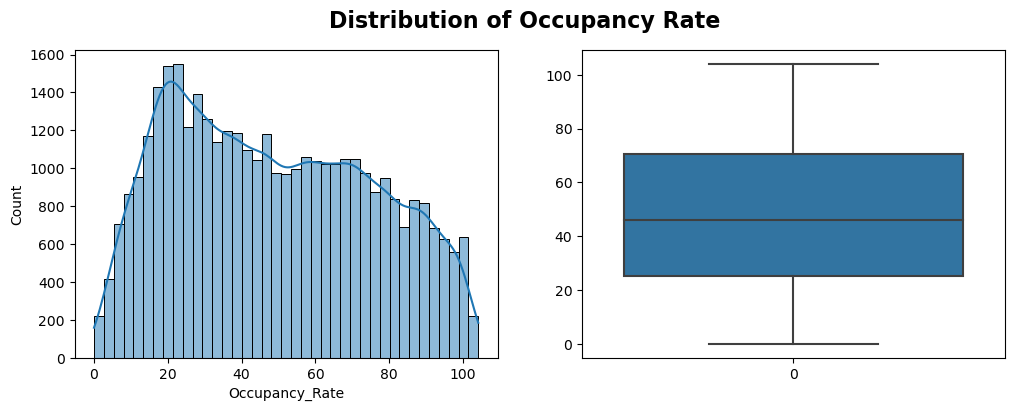

In [70]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df_ts_final['Occupancy_Rate'], kde=True)

plt.subplot(1, 2, 2)
sns.boxplot(df_ts_final['Occupancy_Rate'])

plt.suptitle('Distribution of Occupancy Rate', fontweight='bold', fontsize=16)
plt.show()

In [71]:
def capping_OccRate(occrate):
    
    if occrate>100.0:
        return 100.0
    elif occrate<0.0:
        return 0.0

    return occrate
        

df_ts_final['Occupancy_Rate'] = df_ts_final['Occupancy_Rate'].apply(capping_OccRate)

## Location

In [72]:
# Example time point
viz_ts = '2016-12-19 15:00:00'

# Filter out a particular time point
df_ts_final_onept = df_ts_final.loc[df_ts_final.TimeStamp==viz_ts].copy()

# long_test = -1.743507
# lat_test = 52.452382
# df_ts_final_onept = df_ts_final.loc[(df_ts_final.TimeStamp==viz_ts) & 
#                                     (df_ts_final.Longitude==long_test) & 
#                                     (df_ts_final.Latitude==lat_test)].copy()


# Generate availability rate
df_ts_final_onept['Avail_Rate'] = (100 - df_ts_final_onept['Occupancy_Rate'])

# Create a colormap 
norm = Normalize(vmin=df_ts_final_onept['Avail_Rate'].min(), vmax=df_ts_final_onept['Avail_Rate'].max())

# colormap = colormaps['viridis']
colormap = colormaps['plasma']
# colormap = colormaps['cividis']
# colormap = colormaps['inferno']

# # Create a base map centered around Birmingham, UK
# m = folium.Map(location=[52.4862, -1.8904], zoom_start=12)


# Define the latitude and longitude bounds
min_lat, max_lat = 52.450436, 52.508714
min_lon, max_lon = -1.941379, -1.715727

# Create a base map centered around Birmingham, UK with specified zoom levels
m = folium.Map(
    location=[(min_lat + max_lat) / 2, (min_lon + max_lon) / 2], 
    zoom_start=12, 
    min_zoom=12,  
    max_zoom=14,  
    width='100%', 
    height='600px',
)


# Set latitude and longitude bounds
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])


# Add points to the map
for i, row in df_ts_final_onept.iterrows():
    color_value = colormap(norm(row['Avail_Rate']))  # Normalize and get color
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        # radius=row['Avail_Rate'] / 2.5,  # Adjust size
        radius=(row['Avail_Rate'])**0.7,  # Adjust size
        color='black',
        fill=True,
        
        fill_color='#{:02x}{:02x}{:02x}'.format(int(color_value[0]*255), int(color_value[1]*255), int(color_value[2]*255)),  # Convert to HEX
        fill_opacity=0.8,
        
        # fill_color=clrmap(row['Avail_Rate']),  # Map color
        # fill_opacity=0.75,
        popup=f'Availability Rate: {row["Avail_Rate"]}'
    ).add_to(m)

# Display the map
m

## Extracting temporal Features

In [73]:
df_ts_final

,TimeStamp,ps_idx,Capacity,Occupancy,Occupancy_Rate,Longitude,Latitude
0,2016-10-04 08:00:00,1,577.0,61.0,10.5719,-1.891063,52.475741
1,2016-10-04 08:30:00,1,577.0,64.0,11.0919,-1.891063,52.475741
2,2016-10-04 09:00:00,1,577.0,80.0,13.8648,-1.891063,52.475741
3,2016-10-04 09:30:00,1,577.0,107.0,18.5442,-1.891063,52.475741
4,2016-10-04 10:00:00,1,577.0,150.0,25.9965,-1.891063,52.475741
...,...,...,...,...,...,...,...
37417,2016-12-19 14:30:00,27,1920.0,1517.0,79.0104,-1.858148,52.501235
37418,2016-12-19 15:00:00,27,1920.0,1487.0,77.4479,-1.858148,52.501235
37419,2016-12-19 15:30:00,27,1920.0,1432.0,74.5833,-1.858148,52.501235
37420,2016-12-19 16:00:00,27,1920.0,1321.0,68.8021,-1.858148,52.501235


In [74]:
# Temporal features: Day wise
df_ts_final['Date'] = df_ts_final['TimeStamp'].dt.date
df_ts_final['DayOfWeek'] = df_ts_final['TimeStamp'].dt.dayofweek
df_ts_final['isWeekend'] = df_ts_final['DayOfWeek'].apply(lambda x: True if x in [5, 6] else False)

# Temporal features: Hour wise
df_ts_final['Time'] = df_ts_final['TimeStamp'].dt.time.apply(lambda x: str(x)[:5])
df_ts_final['Hour'] = df_ts_final['TimeStamp'].dt.hour
df_ts_final['Minute'] = df_ts_final['TimeStamp'].dt.minute

## Weekday vs Weekend Analysis

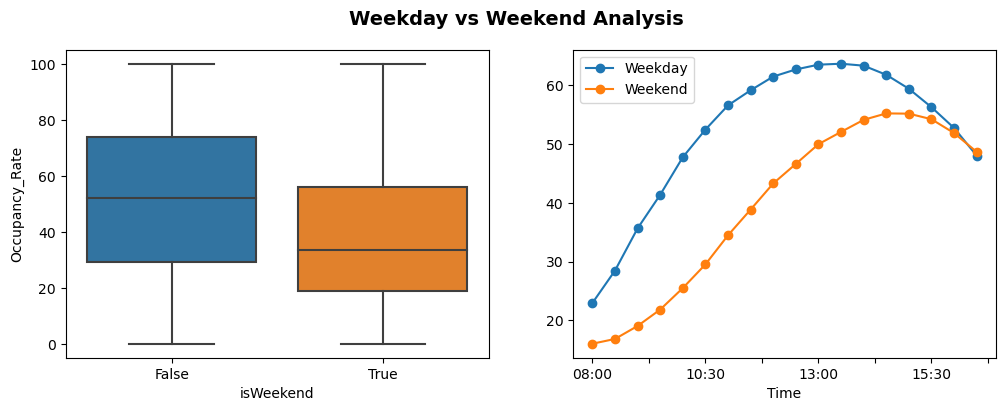

In [75]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_ts_final, x='isWeekend', y='Occupancy_Rate')

plt.subplot(1, 2, 2)
df_ts_final.loc[df_ts_final.isWeekend==False].groupby('Time')['Occupancy_Rate'].mean().plot(marker='o', label='Weekday')
df_ts_final.loc[df_ts_final.isWeekend==True].groupby('Time')['Occupancy_Rate'].mean().plot(marker='o', label='Weekend')
plt.legend()

plt.suptitle('Weekday vs Weekend Analysis', fontweight='bold', fontsize=14)
plt.show()

## Day-Wise Analysis

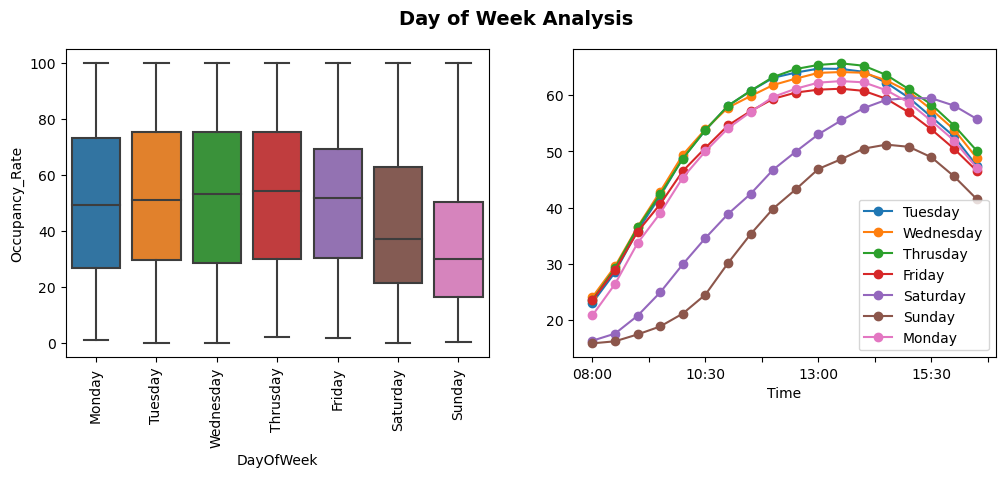

In [76]:
day_dict = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3:'Thrusday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_ts_final, x='DayOfWeek', y='Occupancy_Rate')
plt.xticks(ticks=list(day_dict.keys()), labels=[day_dict[day] for day in day_dict.keys()], rotation=90)

plt.subplot(1, 2, 2)
for day in df_ts_final.DayOfWeek.unique():
    df_ts_final.loc[df_ts_final.DayOfWeek==day].groupby('Time')['Occupancy_Rate'].mean().plot(marker='o', label=day_dict[day])
plt.legend()

plt.suptitle('Day of Week Analysis', fontweight='bold', fontsize=14)
plt.show()

## Generating the individual time series

In [77]:
ts_dict = {}

for ps in df_ts_final['ps_idx'].unique():
    
    # Filter data by park space
    df_ps = df_ts_final.loc[df_ts_final['ps_idx']==ps].copy()
    df_ps.set_index('TimeStamp', inplace=True)
    
    # Sort by Timestamp
    df_ps = df_ps.sort_index()
    
    # Append the series in dictionary
    ts_dict[df_ps['ps_idx'].iloc[0]] = df_ps['Occupancy_Rate']
    
# len(ts_dict.keys())

# Saving the datasets post EDA:

In [78]:
# # Saving the final dataframe (having information for each park space)
# df_ts_final.to_csv(path_or_buf='./data_artifacts/df_ts_final.csv', index=False)

# Modelling: Time Series

In [79]:
# !pip install pmdarima

In [80]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, mean_absolute_percentage_error as mape
import time

import warnings

from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

warnings.filterwarnings("ignore", category=UserWarning)

## Finding Seasonality

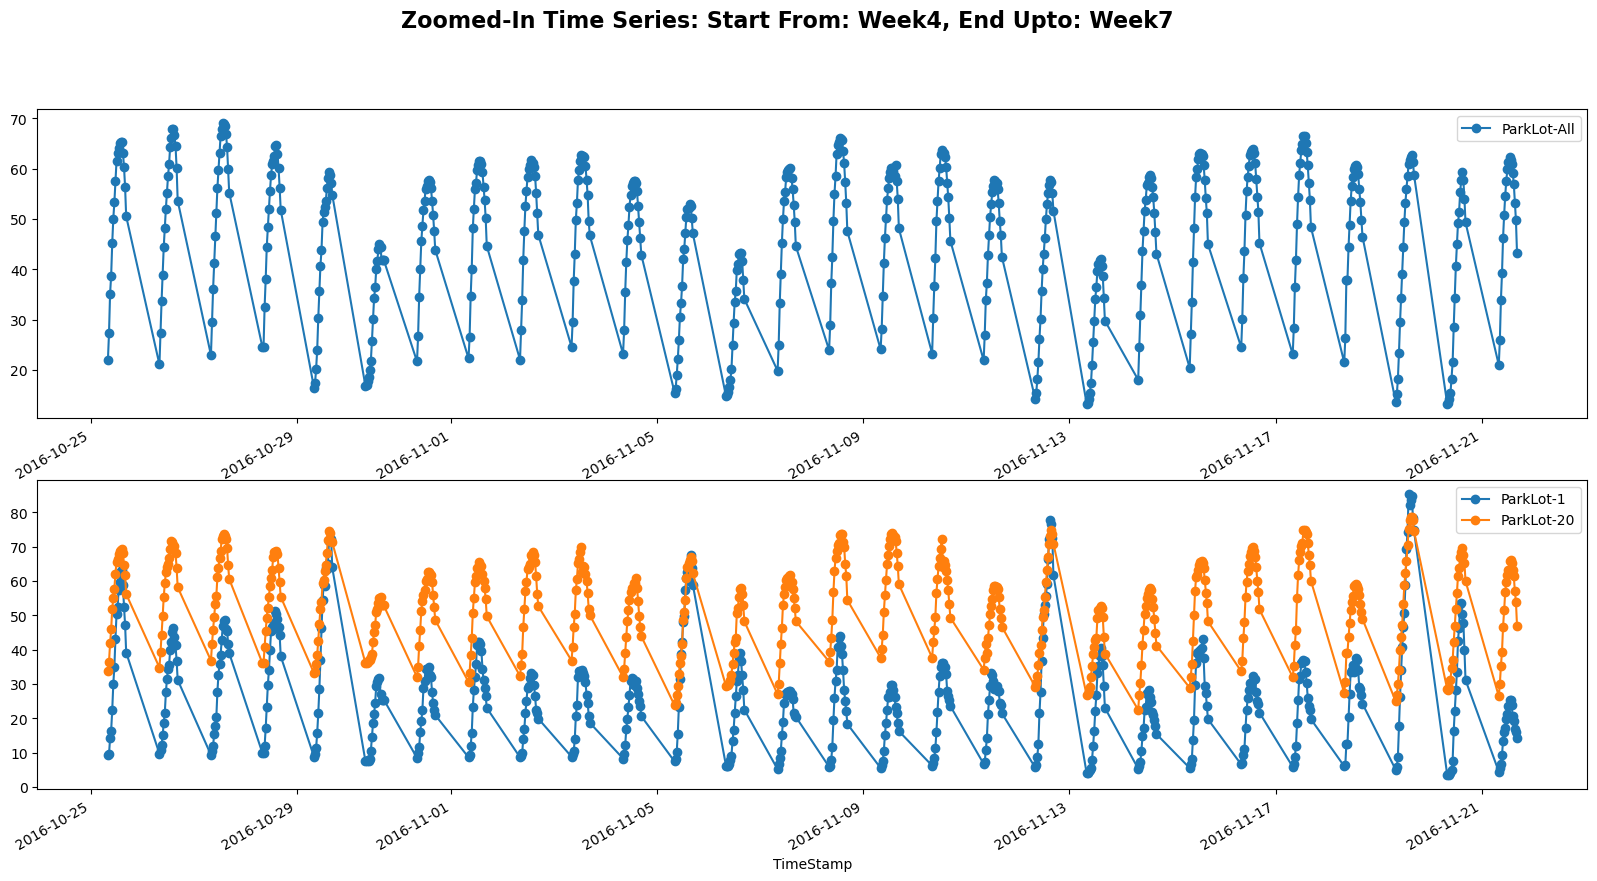

In [81]:
ts_zoomed_start_week = 4
ts_zoomed_end_week = 7
start_index = 0 + (ts_zoomed_start_week-1)*7*18
end_index = 0 + (ts_zoomed_end_week)*7*18


plt.figure(figsize=(20, 10))

plt.subplot(2,1,1)
df_ts_final.groupby('TimeStamp')['Occupancy_Rate'].mean().iloc[start_index:end_index].plot(marker='o', label='ParkLot-All')
plt.legend()


plt.subplot(2,1,2)
df_ts_final.loc[df_ts_final.ps_idx==1].groupby('TimeStamp')['Occupancy_Rate'].mean().iloc[start_index:
                                                                                          end_index].plot(marker='o', label='ParkLot-1')
df_ts_final.loc[df_ts_final.ps_idx==20].groupby('TimeStamp')['Occupancy_Rate'].mean().iloc[start_index:
                                                                                           end_index].plot(marker='o', label='ParkLot-20')
plt.legend()


plt.suptitle(f'Zoomed-In Time Series: Start From: Week{ts_zoomed_start_week}, End Upto: Week{ts_zoomed_end_week}', fontsize=16, fontweight='bold')
plt.show()

**Observations:**
- Time Series does not have trend, but there is definitely a seasonal pattern observed
- Visually, it looks like there is a daily seasonal component
- Additionally, there can be weekly seasonal trends as spotted in some parking lots

In [82]:
# Check ACF plot after 1st order 1st difference
df_ts_all_ps_agg = df_ts_final.groupby('TimeStamp')['Occupancy_Rate'].mean()
# df_ts_all_ps_agg_firstdiff_o1 = df_ts_all_ps_agg - df_ts_all_ps_agg.diff(1)

# plt.figure(figsize=(20, 5))
# df_ts_all_ps_agg_firstdiff_o1.iloc[start_index:end_index].plot(marker='o', label='ParkLot-All')
# plt.show()

# plt.rcParams['figure.figsize'] = (20, 5)
# plot_acf(df_ts_all_ps_agg_firstdiff_o1.dropna(),lags=150)

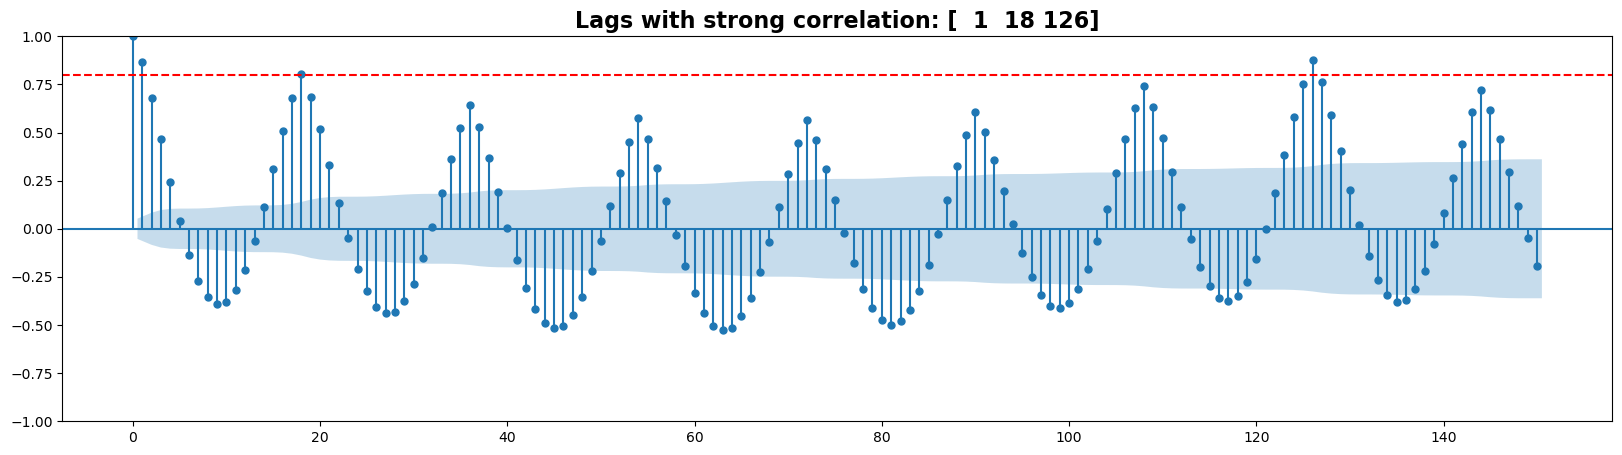

In [83]:
plt.rcParams['figure.figsize'] = (20, 5)
plot_acf(df_ts_all_ps_agg.dropna(),lags=150)
plt.axhline(y=0.8, color='r', linestyle='--')
plt.title(f'Lags with strong correlation: {np.where(acf(df_ts_all_ps_agg, nlags=150)>0.8)[0][1:]}', fontweight='bold', fontsize=16)
plt.show()

## Checking stationarity

In [84]:
def Dickey_Fuller_test(ts,significances_level = 0.05):
    p_value = adfuller(ts)[1]
    if p_value <= significances_level:
        print("Time Series is Stationary")
    else:
        print("Time Series is NOT Stationary")
    print("p_value is: ", p_value)

In [85]:
# Checking aggregated time series
Dickey_Fuller_test(df_ts_all_ps_agg)

Time Series is Stationary
p_value is:  3.600790452431924e-05


## Evaluation Metric

In [86]:
# Creating a function to print values of all these metrics.
def ts_performance_metrics(actual, predicted):
    print('-'*50)
    print('Forecasting Metrics')
    print('-'*50)
    metric_mae = round(mae(actual, predicted), 3)
    metric_rmse = round(mse(actual, predicted)**0.5, 3)
    print('MAE :', metric_mae)
    print('RMSE :', metric_rmse) 
    # print('MAPE:', round(mape(actual, predicted), 3))
    
    return metric_mae, metric_rmse

## Time based splitting for cross validation

### Focusing on the 1st Parking Lot (Will replicate Analysis for other park lots later)

In [87]:
# Defining #points to predict
pts_per_week = 7*18 # 126 points per week (7X18)
predict_points = 1 * pts_per_week  # Use 10 weeks (1260 points) for training

# Sample time series
ts_parklot = ts_dict[1]

# Train-Test Split
ts_parklot_train = ts_parklot.iloc[:-predict_points]
ts_parklot_test = ts_parklot.iloc[-predict_points:]

print(ts_parklot_train.shape)
print(ts_parklot_test.shape)

(1260,)
(126,)


## Simple Exponential Smoothing: SES

### HyperParameter Tuning: SES

Lowest RMSE (CV-10Fold) value of 18.278 found for alpha=0.05


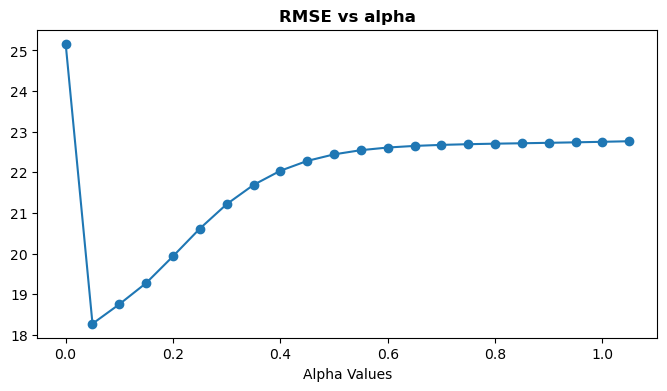

In [88]:
def cross_val_ses(train_data, cv_folds, alpha_vals):
    
    dict_hyp_alpha = {}
    
    # Use the full training data for cross-validation within the training set
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    # Trying out different hyper-parameters
    for alpha in alpha_vals:
        
        cv_errors = []
        
        # Performing cross-validation with the training set
        for train_index, val_index in tscv.split(train_data):
            train_fold = train_data.iloc[train_index]
            val_fold = train_data.iloc[val_index]
            
            # Fit Simple Exponential Smoothing model with the current alpha
            alpha_rnd = round(alpha, 2)
            model = SimpleExpSmoothing(train_fold).fit(smoothing_level=alpha_rnd, optimized=False)

            # Forecast for the validation set
            forecast = model.forecast(len(val_fold))

            # Compute validation error (RMSE)
            rmse_fold = round(mse(val_fold, forecast)**0.5, 3)
            
            # Append RMSE to cv_errors
            cv_errors.append(rmse_fold)
    
    
        # Average validation error for this alpha
        dict_hyp_alpha[alpha_rnd] = round(np.mean(cv_errors), 3)
        
        
    return dict_hyp_alpha
            
            
alpha_values = np.arange(0, 1.1, 0.05)  # Alpha values from 0 to 1
hyp_alpha_dict = cross_val_ses(train_data=ts_parklot_train, 
                               cv_folds=10, 
                               alpha_vals=alpha_values)

argmin_alpha = min(hyp_alpha_dict, key=hyp_alpha_dict.get)
print(f'Lowest RMSE (CV-10Fold) value of {hyp_alpha_dict[argmin_alpha]} found for alpha={argmin_alpha}')

plt.figure(figsize=(8, 4))
plt.plot(hyp_alpha_dict.keys(), hyp_alpha_dict.values(), marker='o')
plt.xlabel('Alpha Values')
plt.title('RMSE vs alpha', fontweight='bold', fontsize=12)
plt.show()

### Forecasting with best parameter

In [89]:
ses_model = SimpleExpSmoothing(ts_parklot_train).fit(smoothing_level=0.02, optimized=False)
ses_forecast = ses_model.forecast(len(ts_parklot_test))
ses_forecast.index = ts_parklot_test.index
fr_mae, fr_rmse = ts_performance_metrics(actual=ts_parklot_test, predicted=ses_forecast)

--------------------------------------------------
Forecasting Metrics
--------------------------------------------------
MAE : 14.239
RMSE : 18.252


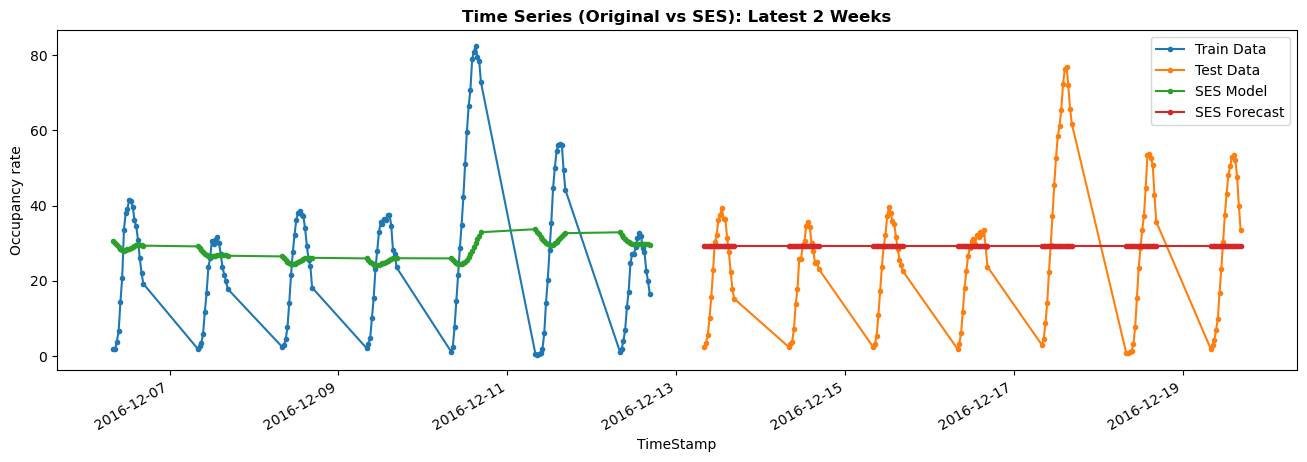

In [90]:
plt.figure(figsize=(16, 5))
ts_parklot_train.iloc[-126:].plot(label='Train Data', marker='.')
ts_parklot_test.plot(label='Test Data', marker='.')
ses_model.fittedvalues.iloc[-126:].plot(label='SES Model', marker='.')
ses_forecast.plot(label='SES Forecast', marker='.')
plt.ylabel('Occupancy rate')
plt.title('Time Series (Original vs SES): Latest 2 Weeks', fontsize=12, fontweight='bold')
plt.legend()
plt.show()

## Triple Exponential Smoothing (TES)

### Hyperparameter Tuning: TES

In [91]:
def cross_val_exp_smooth(train_data, cv_folds, alpha_vals, beta_vals, gamma_vals, season_period):
    
    dict_hyp = {'alpha':[], 'beta':[], 'gamma':[], 'cv_rmse':[], 'cv_mae':[]}
    
    # Use the full training data for cross-validation within the training set
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    
    # Trying out different hyper-parameters
    for alpha in alpha_vals:
        for beta in beta_vals:
            for gamma in gamma_vals:
        
                cv_rmse_lst = []
                cv_mae_lst = []

                # Performing cross-validation with the training set
                for train_index, val_index in tscv.split(train_data):
                    train_fold = train_data.iloc[train_index]
                    val_fold = train_data.iloc[val_index]

                    # Fit Exponential Smoothing model with the current alpha
                    model = ExponentialSmoothing(train_fold, trend='add', seasonal='add', 
                                                 seasonal_periods=season_period).fit(smoothing_level=alpha,                       
                                                                                     smoothing_trend=beta, 
                                                                                     smoothing_seasonal=gamma)
                    

                    # Forecast for the validation set
                    forecast = model.forecast(steps=len(val_fold))
                    
                    # # Debug
                    # print(alpha, beta, gamma, len(val_fold), len(forecast), sum(np.isnan(val_fold)), sum(np.isnan(forecast)))

                    if sum(np.isnan(forecast)) == len(val_fold): 
                        # Ensuring forecasts are not all nans
                        continue
                    else:
                        # Compute validation error (RMSE)
                        rmse_fold = round(mse(val_fold, forecast)**0.5, 3)
                        mae_fold = round(mae(val_fold, forecast), 3)

                        # Append RMSE & MAE to cv_errors
                        cv_rmse_lst.append(rmse_fold)
                        cv_mae_lst.append(mae_fold)


                # Average validation error for current hyperparameter combination
                dict_hyp['alpha'].append(alpha)
                dict_hyp['beta'].append(beta)
                dict_hyp['gamma'].append(gamma)
                dict_hyp['cv_rmse'].append(round(np.mean(cv_rmse_lst), 3))
                dict_hyp['cv_mae'].append(round(np.mean(cv_mae_lst), 3))
        
        
    return dict_hyp
            
            
alpha_values = np.round(np.arange(0, 0.9, 0.15), 2)  # Alpha values from 0 to 1
beta_values = np.round(np.arange(0, 0.9, 0.15), 2)  # Beta values from 0 to 1
gamma_values = np.round(np.arange(0, 0.9, 0.15), 2)  # Gamma values from 0 to 1


start_time = time.time()
tes_hyp_dict = cross_val_exp_smooth(train_data=ts_parklot_train, 
                                    cv_folds=4, 
                                    alpha_vals=alpha_values, 
                                    beta_vals=beta_values,     
                                    gamma_vals=gamma_values, 
                                    season_period=126)
end_time = time.time()
print('-'*50)
print('Computation time:', end_time-start_time)
print('-'*50)

# Top-10 combinations for the TES Model
df_hyp_tes = pd.DataFrame(tes_hyp_dict).sort_values(by='cv_rmse').iloc[:10]
df_hyp_tes

--------------------------------------------------
Computation time: 115.59036016464233
--------------------------------------------------


,alpha,beta,gamma,cv_rmse,cv_mae
181,0.75,0.0,0.15,8.224,6.038
180,0.75,0.0,0.00,8.226,6.055
145,0.60,0.0,0.15,8.233,6.046
144,0.60,0.0,0.00,8.250,6.082
146,0.60,0.0,0.30,8.274,6.079
182,0.75,0.0,0.30,8.284,6.101
109,0.45,0.0,0.15,8.311,6.145
108,0.45,0.0,0.00,8.338,6.196
110,0.45,0.0,0.30,8.342,6.161
147,0.60,0.0,0.45,8.376,6.174


### Forecasting with best parameter

In [92]:
exp_sm_model = ExponentialSmoothing(ts_parklot_train,             
                                    trend='add',          
                                    seasonal='add',           
                                    seasonal_periods=126).fit(smoothing_level=0.75,                            
                                                             smoothing_trend=0,        
                                                             smoothing_seasonal=0.15)

exp_sm_forecast = exp_sm_model.forecast(len(ts_parklot_test))
exp_sm_forecast.index = ts_parklot_test.index
fr_mae, fr_rmse = ts_performance_metrics(actual=ts_parklot_test, predicted=exp_sm_forecast)

--------------------------------------------------
Forecasting Metrics
--------------------------------------------------
MAE : 4.67
RMSE : 7.75


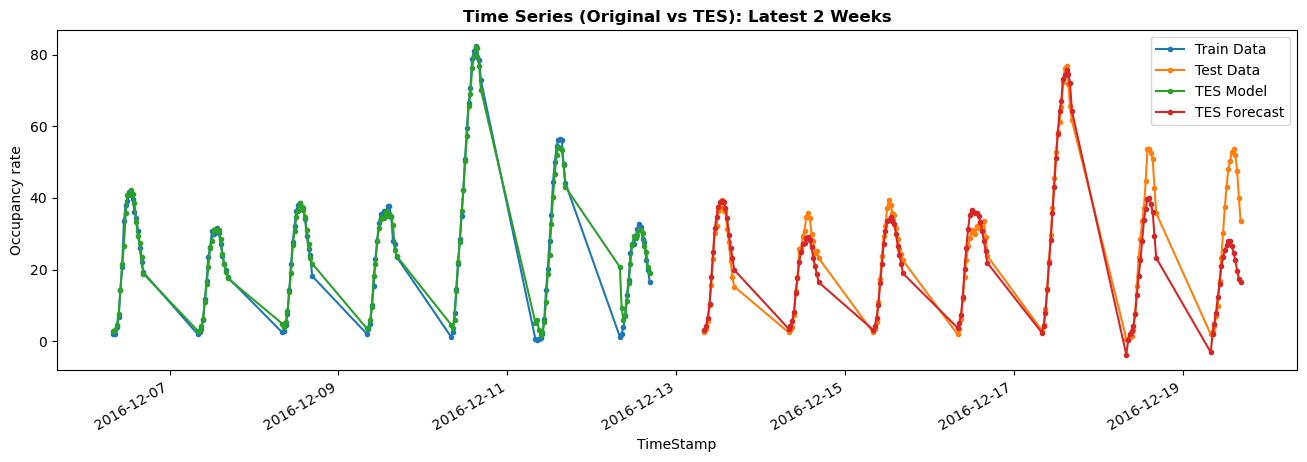

In [93]:
plt.figure(figsize=(16, 5))

plot_train_pts = 18*7*1
ts_parklot_train.iloc[-plot_train_pts:].plot(label='Train Data', marker='.')
ts_parklot_test.plot(label='Test Data', marker='.')
exp_sm_model.fittedvalues.iloc[-plot_train_pts:].plot(label='TES Model', marker='.')
exp_sm_forecast.plot(label='TES Forecast', marker='.')
plt.ylabel('Occupancy rate')
plt.title('Time Series (Original vs TES): Latest 2 Weeks', fontsize=12, fontweight='bold')
plt.legend()
plt.show()

## SARIMA

### Hyperparameter Tuning: SARIMA Ver1 (StatsModel)

In [94]:
# def cross_val_SARIMAX(train_data, cv_folds, p_vals, d_vals, s_vals):
    
#     counter = 0
#     dict_hyp = {'combo_id':[], 'pdq':[], 'PDQs':[], 'cv_rmse':[], 'cv_mae':[]}
    
#     # Use the full training data for cross-validation within the training set
#     tscv = TimeSeriesSplit(n_splits=cv_folds)
    
#     # Trying out different hyper-parameters
#     for p in p_vals:
#         for q in p_vals:
#             for d in d_vals:
#                 for P in p_vals:
#                     for Q in p_vals:
#                         for D in d_vals:
#                             for s in s_vals:
        
#                                 cv_rmse_lst = []
#                                 cv_mae_lst = []

#                                 # Performing cross-validation with the training set
#                                 for train_index, val_index in tscv.split(train_data):
#                                     train_fold = train_data.iloc[train_index]
#                                     val_fold = train_data.iloc[val_index]
                                    

#                                     #Creating SARIMAX Model
#                                     model = SARIMAX(train_fold, 
#                                                     order=(p,d,q), 
#                                                     seasonal_order=(P, D, Q, s), 
#                                                     initialization='approximate_diffuse')
            
#                                     model_fit = model.fit(disp=False)
                
                
#                                     # Forecast for the validation set
#                                     forecast = model_fit.forecast(steps=len(val_fold), dynamic = True)

                                
                                
#                                     if sum(np.isnan(forecast)) == len(val_fold): 
#                                         # Ensuring forecasts are not all nans
#                                         continue
#                                     else:
#                                         # Compute validation error (RMSE)
#                                         rmse_fold = round(mse(val_fold, forecast)**0.5, 3)
#                                         mae_fold = round(mae(val_fold, forecast), 3)

#                                         # Append RMSE & MAE to cv_errors
#                                         cv_rmse_lst.append(rmse_fold)
#                                         cv_mae_lst.append(mae_fold)
                                        
                    
#                                 # Average validation error for current hyperparameter combination
#                                 counter += 1
#                                 dict_hyp['combo_id'].append(counter)
#                                 dict_hyp['pdq'].append((p,d,q))
#                                 dict_hyp['PDQs'].append((P,D,Q,s))
#                                 dict_hyp['cv_rmse'].append(round(np.mean(cv_rmse_lst), 3))
#                                 dict_hyp['cv_mae'].append(round(np.mean(cv_mae_lst), 3))
                                
#                 #print statement to check progress of Loop                
#                 print(f'Possible Combination: {counter*cv_folds} out of { (len(p_vals)**4)*(len(d_vals)**2)*len(s_vals)*cv_folds} calculated')
        
        
#     return dict_hyp


# p_values = [0,1,2]
# d_values = [0,1]
# s_values = [18]

# start_time = time.time()
# sarima_hyp_dict  = cross_val_SARIMAX(train_data=ts_parklot_train, 
#                                      cv_folds=3, 
#                                      p_vals=p_values, 
#                                      d_vals=d_values, 
#                                      s_vals=s_values)
# end_time = time.time()
# print('-'*50)
# print('Computation time:', end_time-start_time)
# print('-'*50)

# # Top-10 combinations for the TES Model
# df_hyp_sarima = pd.DataFrame(sarima_hyp_dict).sort_values(by='cv_rmse').iloc[:10]
# df_hyp_sarima

### Hyperparameter Tuning: SARIMA Ver2 (Auto-ARIMA)

In [95]:
def tune_SARIMAX_v2(train_data, 
                    p_max, q_max, P_max, Q_max, s_val,  
                    random_srch=False, random_srch_fits=10):
    
    # Use pmdarima's auto_arima function to find the best parameters
    model = pm.auto_arima(train_data,
                          
                          
                          # Parameter space: Non-seasonal
                          start_p=0, max_p=p_max,
                          start_q=0, max_q=q_max,
  
                          # Parameter space: Seasonal
                          seasonal=True, 
                          start_P=0, max_P=P_max,
                          start_Q=0, max_Q=Q_max,
                          m=s_val,
 
                          # Differencing: Automatically determine non-seasonal and seasonal differencing order
                          stationary=False,
                          d=0, D=1, 
                              
                          # Whether to perform grid vs random search
                          random=random_srch,
                          n_fits=random_srch_fits,
                              

                          trace=True,                 # print the progress   
                          error_action='ignore',      # ignore if a model does not work  
                          suppress_warnings=True,     # suppress warnings    
                          stepwise=True,              # apply stepwise algorithm for faster processing
                          maxiter = 25, 
                          n_jobs=-1                   # Use all processors  
                         )
    return model  
    

start_time = time.time()
tuned_sarimax_model_with_summary = tune_SARIMAX_v2(train_data=ts_parklot_train, 
                                                   p_max=1, q_max=1,   
                                                   P_max=0, Q_max=0, 
                                                   s_val=18*7,    
                                                   random_srch=True, random_srch_fits=10)
end_time = time.time()
print('-'*50)
print('Computation time:', end_time-start_time)
print('-'*50)
print('TUNED PARAMETERS:')
print(f'Best non-seasonal order: (p,d,q): {tuned_sarimax_model_with_summary.order}')
print(f'Best seasonal order: (P,D,Q): {tuned_sarimax_model_with_summary.seasonal_order}')
print('-'*50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[126] intercept   : AIC=7841.540, Time=10.22 sec
 ARIMA(1,0,0)(0,1,0)[126] intercept   : AIC=5658.330, Time=21.22 sec
 ARIMA(0,0,1)(0,1,0)[126] intercept   : AIC=6818.548, Time=40.26 sec
 ARIMA(0,0,0)(0,1,0)[126]             : AIC=7839.709, Time=6.41 sec
 ARIMA(1,0,1)(0,1,0)[126] intercept   : AIC=5637.294, Time=36.35 sec
 ARIMA(1,0,1)(0,1,0)[126]             : AIC=5635.304, Time=13.40 sec
 ARIMA(0,0,1)(0,1,0)[126]             : AIC=6816.691, Time=12.04 sec
 ARIMA(1,0,0)(0,1,0)[126]             : AIC=5656.338, Time=9.57 sec

Best model:  ARIMA(1,0,1)(0,1,0)[126]          
Total fit time: 149.480 seconds
--------------------------------------------------
Computation time: 149.86410808563232
--------------------------------------------------
TUNED PARAMETERS:
Best non-seasonal order: (p,d,q): (1, 0, 1)
Best seasonal order: (P,D,Q): (0, 1, 0, 126)
--------------------------------------------------


### Forecasting with best parameter

In [96]:
# Parameter Set1: 1, 0, 1 | 0, 1, 0, 126
tuned_sarimax_model_forecast = tuned_sarimax_model_with_summary.predict(n_periods=len(ts_parklot_test))
tuned_sarimax_model_forecast.index = ts_parklot_test.index
fr_mae, fr_rmse = ts_performance_metrics(actual=ts_parklot_test, predicted=tuned_sarimax_model_forecast)

--------------------------------------------------
Forecasting Metrics
--------------------------------------------------
MAE : 3.968
RMSE : 6.485


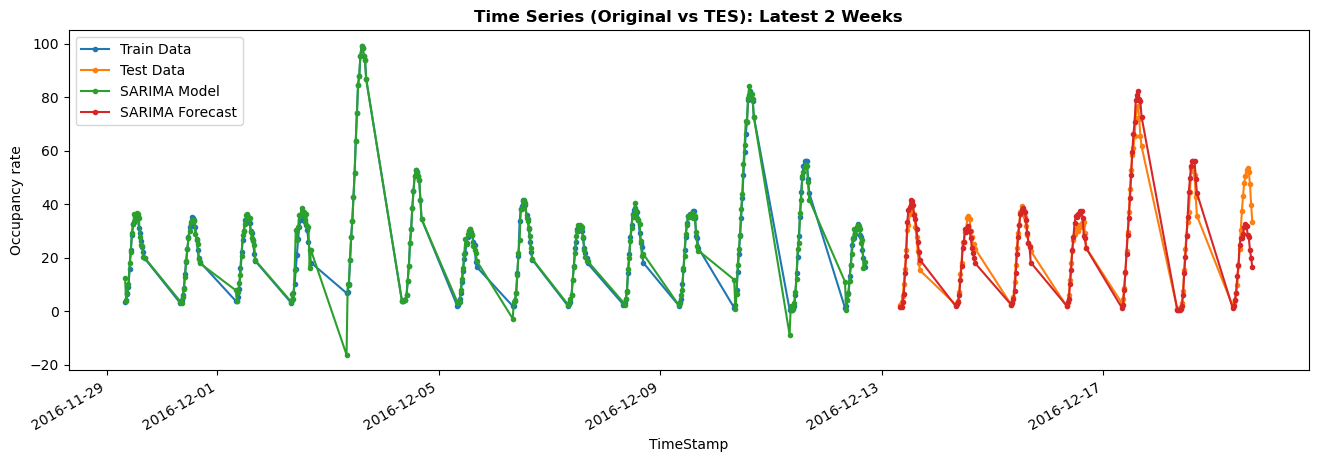

In [97]:
plt.figure(figsize=(16, 5))

plot_train_pts = 18*7*2
ts_parklot_train.iloc[-plot_train_pts:].plot(label='Train Data', marker='.')
ts_parklot_test.plot(label='Test Data', marker='.')
tuned_sarimax_model_with_summary.predict_in_sample().iloc[-plot_train_pts:].plot(label='SARIMA Model', marker='.')
tuned_sarimax_model_forecast.plot(label='SARIMA Forecast', marker='.')
plt.ylabel('Occupancy rate')
plt.title('Time Series (Original vs TES): Latest 2 Weeks', fontsize=12, fontweight='bold')
plt.legend()
plt.show()

# Modelling: Regression

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [104]:
with open('./data_artifacts/fit_models_tes_dict.pkl', 'rb') as f:
    exp_smt_fitted_models_dict = pickle.load(f)

In [106]:
exp_smooth_model_ps1 = exp_smt_fitted_models_dict[1]
ts_parklot_forecast = exp_smooth_model_ps1.forecast(steps=126)
ts_parklot_forecast.index = ts_parklot_test.index
fr_mae, fr_rmse = ts_performance_metrics(actual=ts_parklot_test, predicted=ts_parklot_forecast)

--------------------------------------------------
Forecasting Metrics
--------------------------------------------------
MAE : 4.67
RMSE : 7.75


## Time based Train-Test Split

In [107]:
# Defining #points to predict
pts_per_week = 7*18 # 126 points per week (7X18)
predict_points = 1 * pts_per_week  # Use 10 weeks (1260 points) for training


df_parklot = df_ts_final.loc[df_ts_final.ps_idx==1].copy()
df_parklot['Year'] = pd.to_datetime(df_parklot['Date']).dt.year
df_parklot['Month'] = pd.to_datetime(df_parklot['Date']).dt.month
df_parklot['Day'] = pd.to_datetime(df_parklot['Date']).dt.day


df_parklot_train = df_parklot.iloc[:-predict_points]
df_parklot_test = df_parklot.iloc[-predict_points:]
print(df_parklot_train.shape, df_parklot_test.shape)

(1260, 16) (126, 16)


In [108]:
df_parklot_train_final = df_parklot_train[['TimeStamp', 'Year', 'Month', 'Day', 
                                           'DayOfWeek', 'isWeekend', 'Hour', 'Minute', 
                                           'Capacity', 'Occupancy_Rate']].copy()

df_parklot_test_final = df_parklot_test[['TimeStamp', 'Year', 'Month', 'Day', 
                                         'DayOfWeek', 'isWeekend', 'Hour', 'Minute', 
                                         'Capacity', 'Occupancy_Rate']].copy()

## Feature Engineering

In [109]:
def features_aggregated_lagged(df_inp):
    
    df = df_inp.copy()
    
    # # Aggregated Features: These features would require looking into the future, hence discarding them
    # df['agg_weekend_time'] = df.groupby(['isWeekend', 'Time'])['Occupancy_Rate'].transform(lambda x: x.mean())
    # df['agg_dow_time'] = df.groupby(['DayOfWeek', 'Time'])['Occupancy_Rate'].transform(lambda x: x.mean())
    # df['agg_time'] = df.groupby(['Time'])['Occupancy_Rate'].transform(lambda x: x.mean())
    
    
    # Lagged Features
    df['lag_1'] = df['Occupancy_Rate'].shift(1)
    df['lag_2'] = df['Occupancy_Rate'].shift(2)
    df['lag_3'] = df['Occupancy_Rate'].shift(3)

    df['lag_18'] = df['Occupancy_Rate'].shift(18)
    df['lag_19'] = df['Occupancy_Rate'].shift(19)
    df['lag_20'] = df['Occupancy_Rate'].shift(20)
    
    
    # Encoding Week-Weekend as numeric
    df['isWeekend'] = df['isWeekend'].astype('int')
    
    
    # Impute Missing data with mean imputation
    target_mean = df.Occupancy_Rate.mean()

    df.lag_1.fillna(target_mean, inplace=True)
    df.lag_2.fillna(target_mean, inplace=True)
    df.lag_3.fillna(target_mean, inplace=True)

    df.lag_18.fillna(target_mean, inplace=True)
    df.lag_19.fillna(target_mean, inplace=True)
    df.lag_20.fillna(target_mean, inplace=True)
    
    
    # Setting timestamp as index
    df.set_index('TimeStamp', inplace=True)
    
    return df
    

In [110]:
df_parklot_train_final = features_aggregated_lagged(df_inp=df_parklot_train_final)
df_parklot_test_final = features_aggregated_lagged(df_inp=df_parklot_test_final)

## PreProcessing & Model Training: Helper Functions

In [111]:
def feat_scaler(X_train_inp, X_test_inp):
    
    std_scaler = StandardScaler()
    X_train_inp_scl = std_scaler.fit_transform(X_train_inp)
    X_test_inp_scl = std_scaler.transform(X_test_inp)
    
    return X_train_inp_scl, X_test_inp_scl


def preprocess_pipe(df_train, df_test):
    
    X_train = df_train.drop(['Occupancy_Rate'], axis=1)
    y_train = df_train['Occupancy_Rate']

    X_test = df_test.drop(['Occupancy_Rate'], axis=1)
    y_test = df_test['Occupancy_Rate']
    
    X_train_scl, X_test_scl = feat_scaler(X_train_inp=X_train, X_test_inp=X_test)
    
    return X_train, X_test, X_train_scl, X_test_scl, y_train, y_test


def get_regression_report(model, df_train, X_train, y_train, X_test, y_test):
    
    sep_length = 50
    
    print('REGRESSION REPORT')
    print('-'*sep_length)
    
    # Fit regression model
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    # y_train_pred = pd.Series(y_train_pred)
    # y_train_pred.index = y_train.index
    
    y_test_pred = model.predict(X_test)
    # y_test_pred = pd.Series(y_test_pred)
    # y_test_pred.index = y_test.index
    
    # Model Evaluation metrics
    train_rmse = round(mse(y_train, y_train_pred)**0.5, 3)
    test_rmse = round(mse(y_test, y_test_pred)**0.5, 3)
    
    train_mae = round(mae(y_train, y_train_pred), 3)
    test_mae = round(mae(y_test, y_test_pred), 3)
    
    # Store Fitted Model & Metrics
    # metrics_arr = np.array([])
    metrics_arr = np.array([train_rmse, train_mae, test_rmse, test_mae])
    
    print('Training RMSE:', train_rmse)
    print('Testing RMSE:', test_rmse)
    print('-'*sep_length)
    
    # Feature importances
    ser_feat_imp = pd.Series(model.feature_importances_, index=df_train.columns).sort_values(ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(20, 4))
    plt.bar(ser_feat_imp.index, ser_feat_imp.values)
    plt.xticks(rotation=90)
    plt.show()
    
    return metrics_arr


def plot_test_set_org_predict(y_test, y_pred):
    
    y_pred_ser = pd.Series(y_pred)
    y_pred_ser.index = y_test.index
    
    plt.figure(figsize=(20, 4))
    y_test.plot(marker='o', label='TestSet-Original')
    y_pred_ser.plot(marker='o', label='TestSet-Predicted')
    plt.legend()
    plt.show()

## Feature Scaling

In [112]:
X_train, X_test, X_train_scl, X_test_scl, y_train, y_test = preprocess_pipe(df_train=df_parklot_train_final, 
                                                                            df_test=df_parklot_test_final)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1260, 14) (1260,)
(126, 14) (126,)


## Iteration1: Model Training: RF

In [113]:
X1_train, X1_test, X1_train_scl, X1_test_scl, y1_train, y1_test = preprocess_pipe(df_train=df_parklot_train_final, 
                                                                                  df_test=df_parklot_test_final)

print(X1_train.shape, y1_train.shape)
print(X1_test.shape, y1_test.shape)

(1260, 14) (1260,)
(126, 14) (126,)


REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.808
Testing RMSE: 2.221
--------------------------------------------------


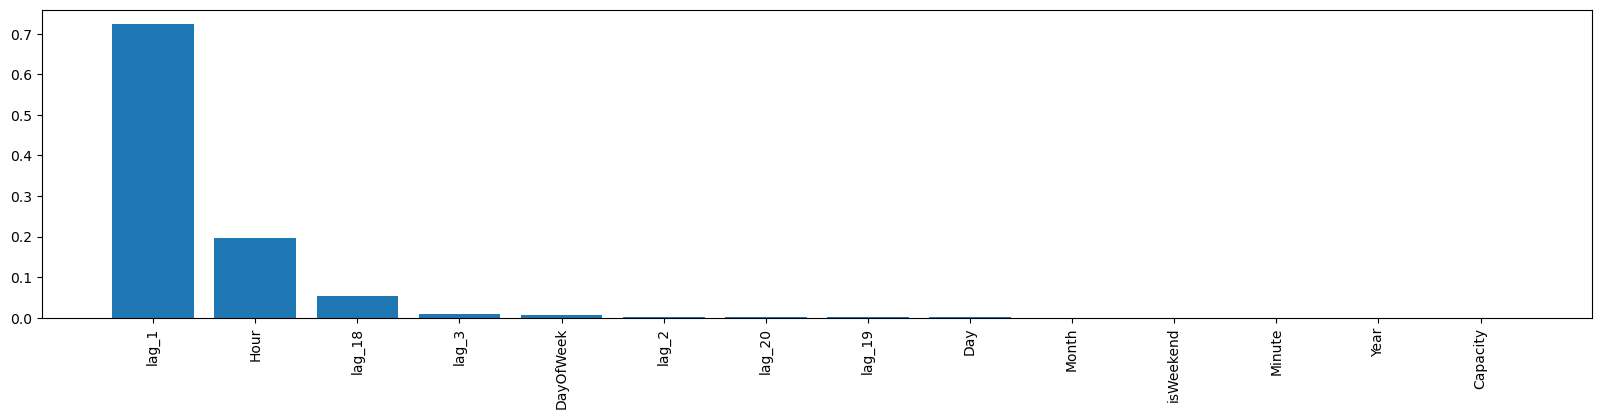

In [114]:
rfr1 = RandomForestRegressor(random_state=42)

iter1_metrics_arr = get_regression_report(model=rfr1, df_train=X1_train, 
                                          X_train=X1_train_scl, 
                                          y_train=y1_train, 
                                          X_test=X1_test_scl, 
                                          y_test=y1_test)

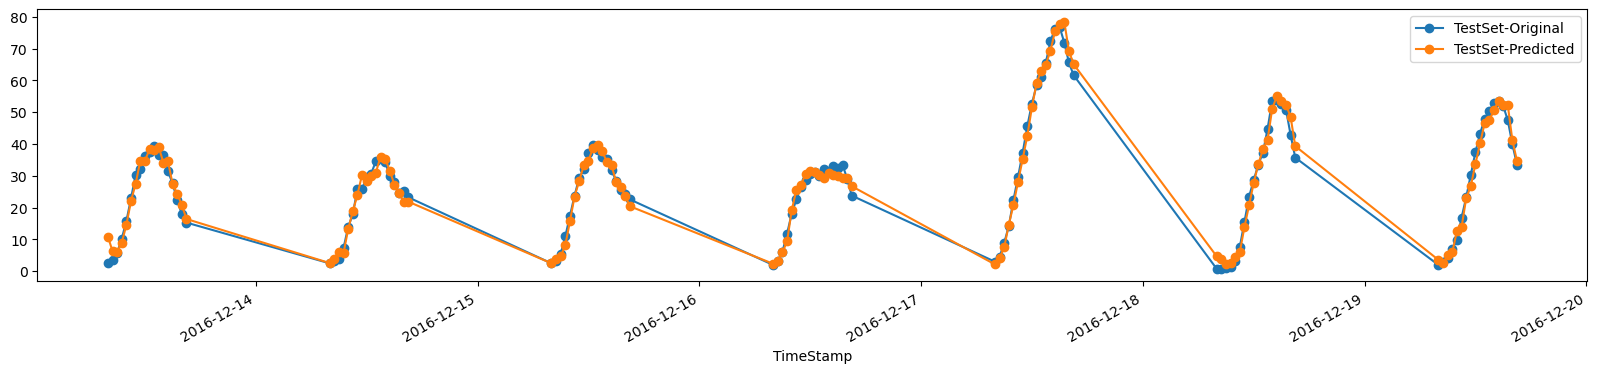

In [115]:
rfr1.fit(X1_train_scl, y1_train)
y1_pred = rfr1.predict(X1_test_scl)
plot_test_set_org_predict(y_test=y1_test, y_pred=y1_pred)

## Iteration2: Model Training: RF + TES Model O/P

In [116]:
ser_exp_smooth_train = exp_smooth_model_ps1.fittedvalues
ser_exp_smooth_train.name='tes_op'

ser_exp_smooth_test = exp_smooth_model_ps1.forecast(steps=df_parklot_test_final.shape[0])
ser_exp_smooth_test.index = ts_parklot_test.index
ser_exp_smooth_test.name='tes_op'

df_parklot_train_final_v2 = pd.merge(df_parklot_train_final, ser_exp_smooth_train, left_index=True, right_index=True)
df_parklot_test_final_v2 = pd.merge(df_parklot_test_final, ser_exp_smooth_test, left_index=True, right_index=True)

print(df_parklot_train_final_v2.shape, df_parklot_test_final_v2.shape)

(1260, 16) (126, 16)


In [117]:
X2_train, X2_test, X2_train_scl, X2_test_scl, y2_train, y2_test = preprocess_pipe(df_train=df_parklot_train_final_v2, 
                                                                                  df_test=df_parklot_test_final_v2)

print(X2_train.shape, y2_train.shape)
print(X2_test.shape, y2_test.shape)

(1260, 15) (1260,)
(126, 15) (126,)


In [118]:
X2_train_scl.shape

(1260, 15)

REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.741
Testing RMSE: 8.62
--------------------------------------------------


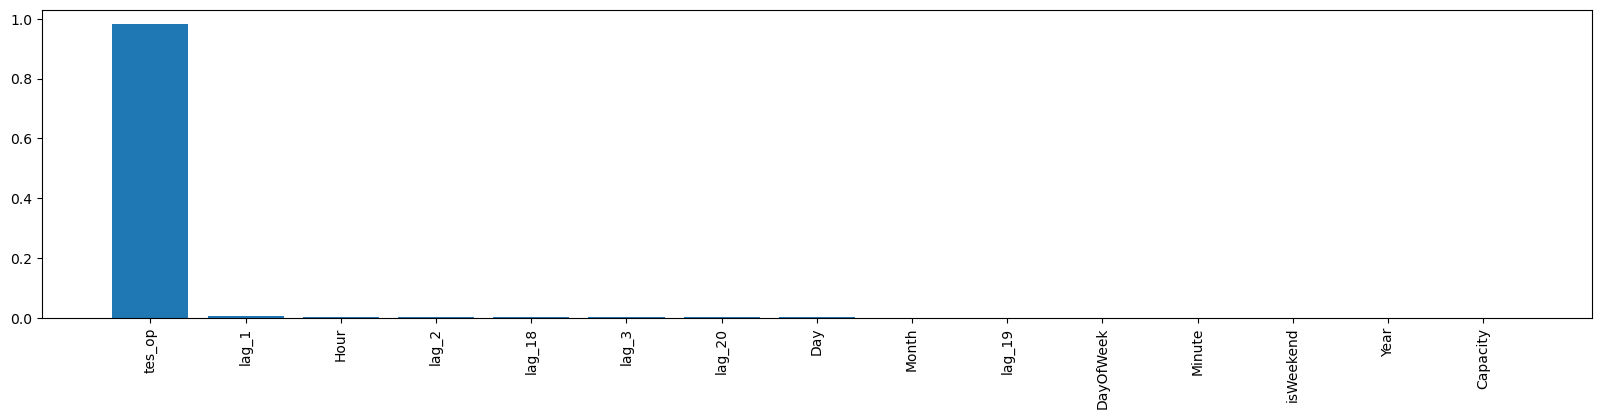

In [119]:
rfr2 = RandomForestRegressor(random_state=42)

iter2_metrics_arr = get_regression_report(model=rfr2, df_train=X2_train, 
                                          X_train=X2_train_scl, 
                                          y_train=y2_train, 
                                          X_test=X2_test_scl, 
                                          y_test=y2_test)

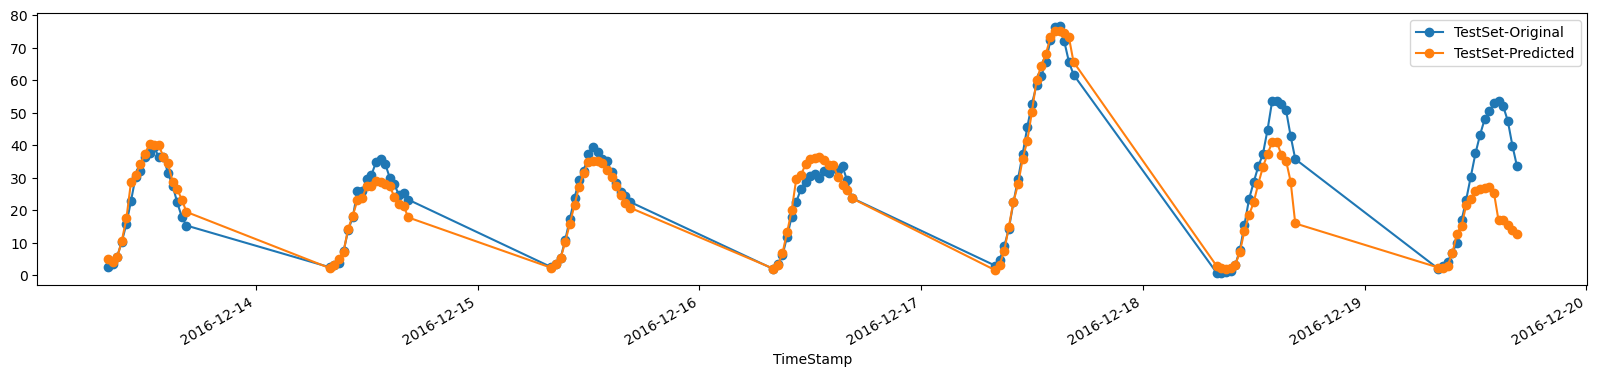

In [120]:
rfr2.fit(X2_train_scl, y2_train)
y2_pred = rfr2.predict(X2_test_scl)
plot_test_set_org_predict(y_test=y2_test, y_pred=y2_pred)

## Iteration3: Model Training: XGBoost

In [121]:
X3_train, X3_test, X3_train_scl, X3_test_scl, y3_train, y3_test = preprocess_pipe(df_train=df_parklot_train_final, 
                                                                                  df_test=df_parklot_test_final)

print(X3_train.shape, y3_train.shape)
print(X3_test.shape, y3_test.shape)

(1260, 14) (1260,)
(126, 14) (126,)


REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.202
Testing RMSE: 2.375
--------------------------------------------------


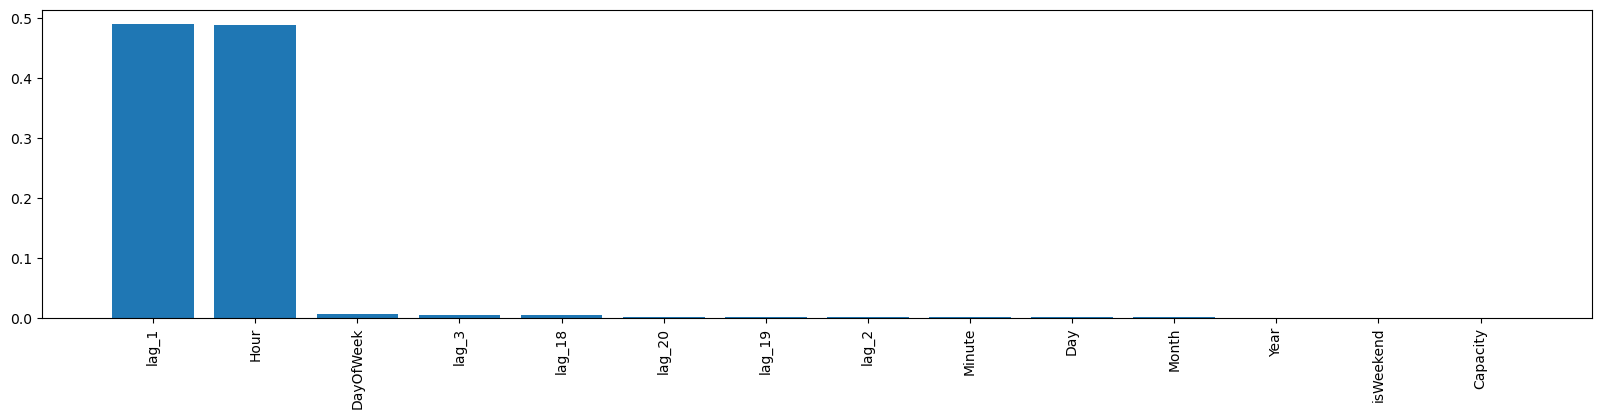

In [122]:
xgbr3 = xgb.XGBRegressor(random_state=42)

iter3_metrics_arr = get_regression_report(model=xgbr3, df_train=X3_train, 
                                          X_train=X3_train_scl, 
                                          y_train=y3_train, 
                                          X_test=X3_test_scl, 
                                          y_test=y3_test)

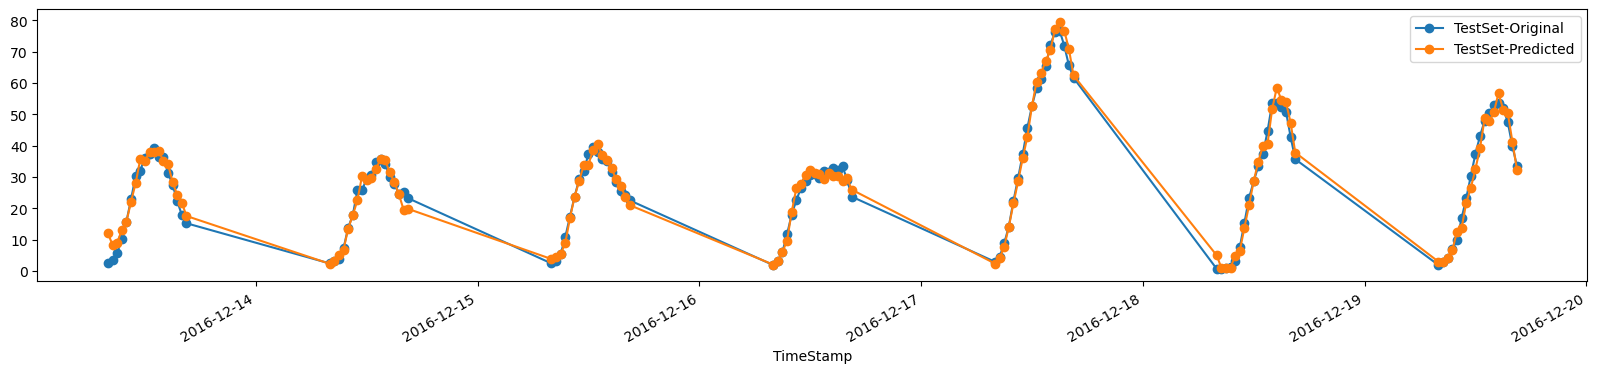

In [123]:
xgbr3.fit(X3_train_scl, y3_train)
y3_pred = xgbr3.predict(X3_test_scl)
plot_test_set_org_predict(y_test=y3_test, y_pred=y3_pred)

## Iteration4: Model Training: XGBoost + TES Model O/P

In [124]:
X4_train, X4_test, X4_train_scl, X4_test_scl, y4_train, y4_test = preprocess_pipe(df_train=df_parklot_train_final_v2, 
                                                                                  df_test=df_parklot_test_final_v2)

print(X4_train.shape, y4_train.shape)
print(X4_test.shape, y4_test.shape)

(1260, 15) (1260,)
(126, 15) (126,)


REGRESSION REPORT
--------------------------------------------------
Training RMSE: 0.158
Testing RMSE: 7.959
--------------------------------------------------


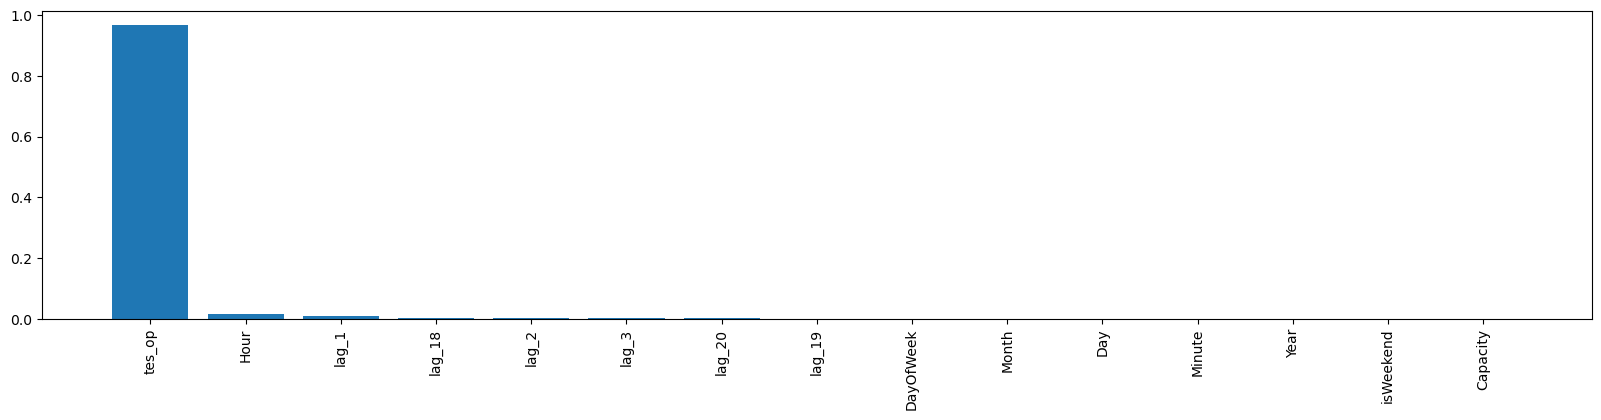

In [125]:
xgbr4 = xgb.XGBRegressor(random_state=42)

iter4_metrics_arr = get_regression_report(model=xgbr4, df_train=X4_train, 
                                          X_train=X4_train_scl, 
                                          y_train=y4_train, 
                                          X_test=X4_test_scl, 
                                          y_test=y4_test)

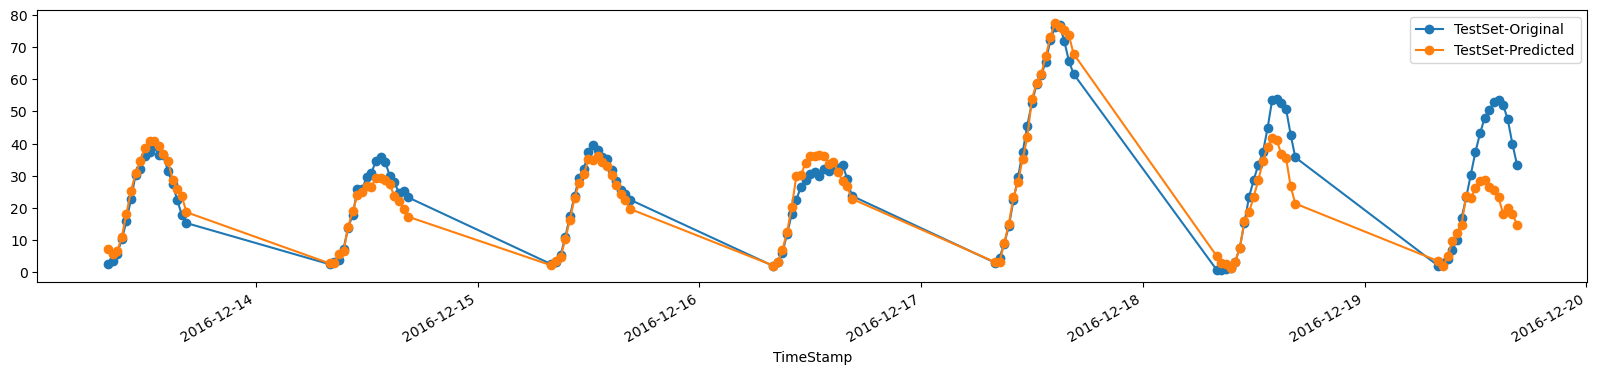

In [128]:
xgbr4.fit(X4_train_scl, y4_train)
y4_pred = xgbr4.predict(X4_test_scl)
plot_test_set_org_predict(y_test=y4_test, y_pred=y4_pred)